80
80


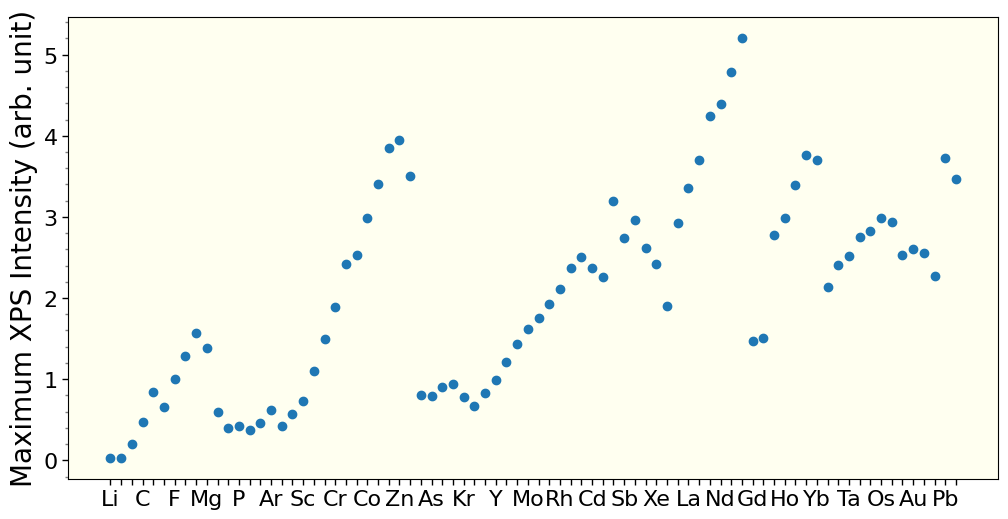

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys,re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import losses
#from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Attention, MultiHeadAttention
from keras_multi_head import MultiHead

tf.keras.backend.clear_session()
tf.random.set_seed(17)
np.random.seed(17)

class Info:
    INPUT_SZ = 2048
    SPECIES = [
    "Li", "Be", "B", "C", "N", "O", "F", "Ne", "Na", "Mg", "Al", "Si", "P",
    "S", "Cl", "Ar", "K", "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni",
    "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y", "Zr",
    "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te",
    "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd", "Sm", "Eu", "Gd", "Tb",
    "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir",
    "Pt", "Au", "Hg", "Tl", "Pb", "Bi"
    ]
    NSPECIES=None
    T=None
    
Info.NSPECIES = len(Info.SPECIES)
print(Info.NSPECIES)
apath = "C:/Users/Inho Lee/testAI/trainXPS/T.txt"
Info.T = pd.read_csv(apath, header=None)[0]
print(len(Info.T))
if False:
    for i in range(len(Info.T)):
        print(Info.SPECIES[i],Info.T[i])


import seaborn as sns
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)    
ind = np.arange(Info.NSPECIES)
plt.rcParams['figure.figsize'] = [12, 6]
fig, ax = plt.subplots()
plt.scatter(ind,Info.T)
#plt.title('YS_PARK XPS', fontsize=20)
plt.xlabel('', fontsize=1)
plt.ylabel('Maximum XPS Intensity (arb. unit)', fontsize=20)
#plt.xticks(ind, Info.SPECIES, fontsize=7)
zlist=[]
for i in range(len(Info.SPECIES)):
    if np.mod(i,3) == 0 :
        zlist.append(Info.SPECIES[i])
    else:
        zlist.append(" ")
plt.xticks(ind, zlist, fontsize=18)
ax.set_facecolor('ivory')
ax.yaxis.set_major_locator(MultipleLocator(1.0))
# ax.yaxis.set_major_formatter('{x:.000f}')
# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=1)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2, color='gray')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('my_plot1.eps')
plt.show()    

In [2]:
def append_new_line(file_name, text_to_append):
    with open(file_name, "a+") as file_object:
        file_object.seek(0)
        data = file_object.read(100)
        if len(data) > 0:
            file_object.write("\n")
        file_object.write(text_to_append)
def append_multiple_lines(file_name, lines_to_append):
    with open(file_name, "a+") as file_object:
        appendEOL = False
        file_object.seek(0)
        data = file_object.read(100)
        if len(data) > 0:
            appendEOL = True
        for line in lines_to_append:
            if appendEOL == True:
                file_object.write("\n")
            else:
                appendEOL = True
            file_object.write(line)

In [3]:
def get_composition(str3):
    patterns = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al',
                'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn',
                'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb',
                'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In',
                'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm',
                'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta',
                'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At',
                'Rn']
    rx = fr'({"|".join(sorted(patterns, key=len,reverse=True))})(\d+(?:\.\d+)?)?'
    df = pd.DataFrame({'formulas': [str3]})
    df['result'] = df['formulas'].str.findall(rx)
    df['result'] = df['result'].apply(
        lambda m: [(x, y) if y else (x, 1) for x, y in m])
    return df['result'][0]


def getxps(directory):
    files = os.listdir(directory)
    formula = ""
    ydum = 0.
    nfiles = 0
    for file in files:
        if file[0] == '.':
            continue
        nfiles = nfiles+1
    X = np.zeros((nfiles, Info.INPUT_SZ), dtype=float)
    y = np.zeros((nfiles, len(Info.SPECIES)+1), dtype=float)
    kase = 0
    for file in files:
        if file[0] == '.':
            continue
        fname = directory + '/' + file
        afile = open(fname, 'r')
        jline = 0
        for line in afile:
            if line.startswith('#'):
                input0 = line
                line0 = line.replace('#', " ")
                line1 = line0.replace('/', " ")
                line2 = line1.replace('[', " ")
                line3 = line2.replace(']', " ")
                ndum = len(line3.split())
                formula = ""
                for i in range(ndum-1):
                    formula = formula+line3.split()[i]
                y[kase, -1] = (float(line3.split()[-1]))/40.
                alist = []
                blist = []
                str2 = get_composition(formula)
                for i in range(len(str2)):
                    a0, a1 = str2[i]
                    blist.append(float(a1))
                tmp = sum(blist)
                blist = [blist[i]/tmp for i in range(len(blist))]
                for i in range(len(str2)):
                    a0, a1 = str2[i]
                    alist.append(blist[i]*Info.T[Info.SPECIES.index(a0)])
                tmq = sum(alist)
                alist = [alist[i]/tmq for i in range(len(alist))]
                for i in range(len(str2)):
                    a0, a1 = str2[i]
                    y[kase, Info.SPECIES.index(a0)] = y[kase,
                                                   Info.SPECIES.index(a0)]+alist[i]
                if False:
                    print(label0(input0))
                    print(y[kase, 0:Info.NSPECIES])
                continue
            X[kase, jline] = float(line.split()[1])
            jline = jline+1
        afile.close()
        kase = kase+1
    return X, y


def getxps1(directory):
    files = os.listdir(directory)
    formula = ""
    ydum = 0.
    nfiles = 0
    for file in files:
        if file[0] == '.':
            continue
        nfiles = nfiles+1
    nfiles0 = nfiles
    nfiles = 2*nfiles0
    X = np.zeros((nfiles, Info.INPUT_SZ), dtype=float)
    y = np.zeros((nfiles, Info.NSPECIES+1), dtype=float)
    kase = 0
    for file in files:
        if file[0] == '.':
            continue
        fname = directory + '/' + file
        afile = open(fname, 'r')
        jline = 0
        for line in afile:
            if line.startswith('#'):
                input0 = line
                line0 = line.replace('#', " ")
                line1 = line0.replace('/', " ")
                line2 = line1.replace('[', " ")
                line3 = line2.replace(']', " ")
                ndum = len(line3.split())
                formula = ""
                for i in range(ndum-1):
                    formula = formula+line3.split()[i]
                y[kase, -1] = (float(line3.split()[-1]))/40.
                alist = []
                blist = []
                str2 = get_composition(formula)
                for i in range(len(str2)):
                    a0, a1 = str2[i]
                    blist.append(float(a1))
                tmp = sum(blist)
                blist = [blist[i]/tmp for i in range(len(blist))]
                for i in range(len(str2)):
                    a0, a1 = str2[i]
                    alist.append(blist[i]*Info.T[Info.SPECIES.index(a0)])
                tmq = sum(alist)
                alist = [alist[i]/tmq for i in range(len(alist))]
                for i in range(len(str2)):
                    a0, a1 = str2[i]
                    y[kase, Info.SPECIES.index(a0)] = y[kase,
                                                   Info.SPECIES.index(a0)]+alist[i]
                if False:
                    print(label0(input0))
                    print(y[kase, 0:Info.NSPECIES])
                continue
            X[kase, jline] = float(line.split()[1])
            jline = jline+1
        afile.close()
        kase = kase+1
    for kase in range(nfiles0):
        X[kase+nfiles0, :] = X[kase, :]
        y[kase+nfiles0, :] = y[kase, :]
        for jline in range(Info.INPUT_SZ):
            X[kase+nfiles0, jline] = X[kase+nfiles0, jline] + \
                (np.random.random()-0.5)*0.0002
    return X, y

In [4]:
class MaskedCategoricalCrossentropy(tf.keras.losses.CategoricalCrossentropy):
    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        mask = y_true > 0.01 
        y_true = y_true[mask]
        y_pred = y_pred[mask]
        return super().call(y_true, y_pred)+mse

In [5]:
def HighPassLoss(y_true, y_pred):
    # High-pass Filters
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
#    y1 = tf.pow(y_pred - y_true, 4)
    y = tf.math.multiply(tf.pow(y_true, 2), tf.pow(y_pred - y_true, 2))
    return tf.reduce_sum(y, 0) #+ tf.reduce_sum(y1, 0)

In [6]:
def get_dropout(input_tensor, p=0.1, mc=False):
    if mc:
        return tf.keras.layers.Dropout(p)(input_tensor, training=True)
    else:
        return tf.keras.layers.Dropout(p)(input_tensor)

In [7]:
# Stage 1(Denoising)
inputs = keras.layers.Input(shape=(Info.INPUT_SZ, 1))
c1 = keras.layers.Conv1D(filters=1,
                         kernel_size=11,
                         strides=1,
                         padding='same',
                         activation=keras.activations.relu,
                         use_bias=False)(inputs)
c2 = keras.layers.Conv1D(filters=1,
                         kernel_size=21,
                         strides=1,
                         padding='same',
                         activation=keras.activations.relu,
                         use_bias=False)(inputs)
c3 = keras.layers.Conv1D(filters=1,
                         kernel_size=41,
                         strides=1,
                         padding='same',
                         activation=keras.activations.relu,
                         use_bias=False)(inputs)
c10 = keras.layers.Conv1D(filters=1,
                          kernel_size=9,
                          strides=1,
                          padding='same',
                          activation=keras.activations.relu,
                          use_bias=False)(inputs)
c20 = keras.layers.Conv1D(filters=1,
                          kernel_size=7,
                          strides=1,
                          padding='same',
                          activation=keras.activations.relu,
                          use_bias=False)(inputs)
if True:
    layer = MultiHeadAttention(num_heads=4, key_dim=64)
    target = tf.keras.Input(shape=[Info.INPUT_SZ, 1])
    source = tf.keras.Input(shape=[Info.INPUT_SZ, 1])
    output_tensor, weights = layer(target, source,
                                   return_attention_scores=True)
    c30 = layer(inputs, inputs)
    x = tf.keras.layers.Concatenate(axis=2)([c1, c2, c3, c10, c20, c30])
else:
    # Concatenate(axis=2)
    x = tf.keras.layers.Concatenate(axis=2)([c1, c2, c3, c10, c20])
print(x.shape)
# Conv1D layers with 4 filters
x = tf.keras.layers.Conv1D(filters=4,
                           kernel_size=5,
                           strides=1,
                           padding='same',
                           activation=keras.activations.relu,
                           use_bias=False)(x)
x = tf.keras.layers.MaxPooling1D(pool_size=4, strides=None)(x)
st1 = tf.keras.layers.Flatten()(x)
# Stage 2(Contamination)
x = get_dropout(st1, p=0.1, mc=True)
x = tf.keras.layers.Dense(units=100, activation=keras.activations.sigmoid,
                          )(x)
x = get_dropout(x, p=0.1, mc=True)
x = tf.keras.layers.Dense(units=100, activation=keras.activations.sigmoid,
                          )(x)
st2 = tf.keras.layers.Dense(units=1,
                            activation=keras.activations.sigmoid,
                            # kernel_regularizer=regularizers.L1L2( l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4),
                            name="conta")(x)
# Stage 3(Quantification)
x = tf.keras.layers.Concatenate(axis=1)([st2, st1])
x = get_dropout(x, p=0.1, mc=True)
# Dense 2048(ReLU)-Cutomregularizer
x = tf.keras.layers.Dense(units=Info.INPUT_SZ, activation=keras.activations.relu
                          )(x)
x = get_dropout(x, p=0.1, mc=True)
x = tf.keras.layers.Dense(units=Info.INPUT_SZ, activation=keras.activations.relu
                          )(x)
# Dense NSPECIES(Sigmoid)-Customregularizer
st3 = tf.keras.layers.Dense(units=Info.NSPECIES,
                            activation=keras.activations.softmax
                            )(x)
model = keras.Model(inputs=inputs, outputs=[st2, st3], name='XPS_CSIAN')
model.summary()
tf.keras.utils.plot_model(
    model, to_file="C:/Users/Inho Lee/testAI/trainXPS/model/model_plot.png", show_shapes=True, show_layer_names=True)
# Contamination-L2_loss, Quantification-HighPassLoss

lhighpass = False
if lhighpass:
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-9),
                  loss=[losses.Huber(delta=0.08), HighPassLoss])

else:
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-9),
                  loss=[losses.MeanSquaredLogarithmicError(), losses.MeanSquaredLogarithmicError()])

(None, 2048, 6)
Model: "XPS_CSIAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 1)      11          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 2048, 1)      21          ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 2048, 1)      41          ['input_1[0][0]']                
                                                                          

training mode

In [8]:
if True:
    if os.path.exists("C:/Users/Inho Lee/testAI/trainXPS/model/conv1.txt"):
        os.remove("C:/Users/Inho Lee/testAI/trainXPS/model/conv1.txt")
    if os.path.exists("C:/Users/Inho Lee/testAI/trainXPS/model/XPS_model1.h5"):
        model = keras.models.load_model(
            "C:/Users/Inho Lee/testAI/trainXPS/model/XPS_model1.h5", compile=False)
        if lhighpass:
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-9),
                          loss=[losses.Huber(delta=0.08), HighPassLoss])
        else:
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-9),
                          loss=[losses.MeanSquaredLogarithmicError(), losses.MeanSquaredLogarithmicError()])
        model.summary()
    EPOCHS = 40
    BATCH_SZ = 10
    NDIR = 75
    tLoss1 = list()
    tLoss2 = list()
    vLoss1 = list()
    vLoss2 = list()
    for epoch in range(EPOCHS):
        tl1 = 0.
        tl2 = 0.
        i = 0
        for dirNum in range(1, NDIR+1):
            directory = "C:/Users/Inho Lee/testAI/trainXPS/data_merge/dir_%d" % dirNum
            X, y = getxps1(directory)
            nsamples = y.shape[0]
            lab2 = np.zeros((nsamples, 1), dtype=float)
            lab1 = np.zeros((nsamples, Info.NSPECIES), dtype=float)
            lab2[:, 0] = y[:, -1]
            lab1[:, 0:Info.NSPECIES] = y[:, 0:Info.NSPECIES]
            if True:
                history = model.fit(X, [lab2, lab1],
                                    batch_size=BATCH_SZ,
                                    verbose=1, epochs=epoch+1, initial_epoch=epoch, shuffle=True)
            tl1 += history.history["conta_loss"][0]
            tl2 += history.history["dense_4_loss"][0]
            i += 1
            print("[%d/%d] TRAINING %d-%d" % (epoch, EPOCHS, dirNum, NDIR))
        tLoss1.append(tl1 / i)
        tLoss2.append(tl2 / i)
        X, y = getxps("C:/Users/Inho Lee/testAI/trainXPS/validation")
        nsamples = y.shape[0]
        lab2 = np.zeros((nsamples, 1), dtype=float)
        lab1 = np.zeros((nsamples, Info.NSPECIES), dtype=float)
        lab2[:, 0] = y[:, -1]
        lab1[:, 0:Info.NSPECIES] = y[:, 0:Info.NSPECIES]
        history = model.evaluate(X, [lab2, lab1], batch_size = BATCH_SZ)
        vLoss1.append(history[1])
        vLoss2.append(history[2])
        lines_to_append = [str(epoch)+' '+str(tl1 / i)+' ' +
                           str(tl2 / i)+' '+str(history[1])+' '+str(history[2])]
        append_multiple_lines(
            "C:/Users/Inho Lee/testAI/trainXPS/model/conv1.txt", lines_to_append)
        if os.path.exists("C:/Users/Inho Lee/testAI/trainXPS/model/XPS_model1.h5"):
            os.remove("C:/Users/Inho Lee/testAI/trainXPS/model/XPS_model1.h5")
        model.save("C:/Users/Inho Lee/testAI/trainXPS/model/XPS_model1.h5")
    if True:
        if os.path.exists("C:/Users/Inho Lee/testAI/trainXPS/model/XPS_model1.h5"):
            os.remove("C:/Users/Inho Lee/testAI/trainXPS/model/XPS_model1.h5")
        model.save("C:/Users/Inho Lee/testAI/trainXPS/model/XPS_model1.h5")

200/200 [==============================] - 22s 93ms/step - loss: 0.0426 - conta_loss: 0.0385 - dense_4_loss: 0.0041
[0/40] TRAINING 1-75
200/200 [==============================] - 19s 95ms/step - loss: 0.0353 - conta_loss: 0.0315 - dense_4_loss: 0.0039
[0/40] TRAINING 2-75
200/200 [==============================] - 19s 93ms/step - loss: 0.0263 - conta_loss: 0.0230 - dense_4_loss: 0.0033
[0/40] TRAINING 3-75
200/200 [==============================] - 19s 95ms/step - loss: 0.0211 - conta_loss: 0.0185 - dense_4_loss: 0.0026
[0/40] TRAINING 4-75
200/200 [==============================] - 19s 94ms/step - loss: 0.0152 - conta_loss: 0.0131 - dense_4_loss: 0.0022
[0/40] TRAINING 5-75
200/200 [==============================] - 19s 95ms/step - loss: 0.0134 - conta_loss: 0.0113 - dense_4_loss: 0.0021
[0/40] TRAINING 6-75
200/200 [==============================] - 19s 95ms/step - loss: 0.0103 - conta_loss: 0.0084 - dense_4_loss: 0.0018
[0/40] TRAINING 7-75
200/200 [==============================] 

200/200 [==============================] - 19s 96ms/step - loss: 0.0032 - conta_loss: 0.0026 - dense_4_loss: 6.3094e-04
[0/40] TRAINING 59-75
200/200 [==============================] - 19s 95ms/step - loss: 0.0038 - conta_loss: 0.0032 - dense_4_loss: 6.7246e-04
[0/40] TRAINING 60-75
200/200 [==============================] - 19s 95ms/step - loss: 0.0026 - conta_loss: 0.0020 - dense_4_loss: 6.4176e-04
[0/40] TRAINING 61-75
200/200 [==============================] - 19s 96ms/step - loss: 0.0027 - conta_loss: 0.0021 - dense_4_loss: 6.2804e-04
[0/40] TRAINING 62-75
200/200 [==============================] - 19s 93ms/step - loss: 0.0028 - conta_loss: 0.0022 - dense_4_loss: 6.2025e-04
[0/40] TRAINING 63-75
200/200 [==============================] - 19s 95ms/step - loss: 0.0028 - conta_loss: 0.0022 - dense_4_loss: 6.0934e-04
[0/40] TRAINING 64-75
200/200 [==============================] - 19s 95ms/step - loss: 0.0044 - conta_loss: 0.0037 - dense_4_loss: 6.7284e-04
[0/40] TRAINING 65-75
200/20

200/200 [==============================] - 19s 92ms/step - loss: 0.0026 - conta_loss: 0.0022 - dense_4_loss: 4.0507e-04
[1/40] TRAINING 38-75
Epoch 2/2
200/200 [==============================] - 19s 92ms/step - loss: 0.0025 - conta_loss: 0.0021 - dense_4_loss: 4.2161e-04
[1/40] TRAINING 39-75
Epoch 2/2
200/200 [==============================] - 19s 92ms/step - loss: 0.0044 - conta_loss: 0.0039 - dense_4_loss: 5.2289e-04
[1/40] TRAINING 40-75
Epoch 2/2
200/200 [==============================] - 19s 93ms/step - loss: 0.0023 - conta_loss: 0.0019 - dense_4_loss: 3.5559e-04
[1/40] TRAINING 41-75
Epoch 2/2
200/200 [==============================] - 19s 92ms/step - loss: 0.0020 - conta_loss: 0.0016 - dense_4_loss: 3.7228e-04
[1/40] TRAINING 42-75
Epoch 2/2
200/200 [==============================] - 19s 92ms/step - loss: 0.0027 - conta_loss: 0.0023 - dense_4_loss: 3.8829e-04
[1/40] TRAINING 43-75
Epoch 2/2
200/200 [==============================] - 19s 92ms/step - loss: 0.0037 - conta_loss: 0.

200/200 [==============================] - 19s 92ms/step - loss: 0.0022 - conta_loss: 0.0019 - dense_4_loss: 3.2233e-04
[2/40] TRAINING 16-75
Epoch 3/3
200/200 [==============================] - 19s 92ms/step - loss: 0.0022 - conta_loss: 0.0018 - dense_4_loss: 3.2664e-04
[2/40] TRAINING 17-75
Epoch 3/3
200/200 [==============================] - 18s 91ms/step - loss: 0.0020 - conta_loss: 0.0017 - dense_4_loss: 3.1246e-04
[2/40] TRAINING 18-75
Epoch 3/3
200/200 [==============================] - 19s 92ms/step - loss: 0.0020 - conta_loss: 0.0017 - dense_4_loss: 3.2936e-04
[2/40] TRAINING 19-75
Epoch 3/3
200/200 [==============================] - 19s 91ms/step - loss: 0.0021 - conta_loss: 0.0018 - dense_4_loss: 3.2427e-04
[2/40] TRAINING 20-75
Epoch 3/3
200/200 [==============================] - 19s 92ms/step - loss: 0.0017 - conta_loss: 0.0014 - dense_4_loss: 2.8029e-04
[2/40] TRAINING 21-75
Epoch 3/3
200/200 [==============================] - 19s 92ms/step - loss: 0.0016 - conta_loss: 0.

Epoch 3/3
200/200 [==============================] - 19s 96ms/step - loss: 0.0013 - conta_loss: 0.0010 - dense_4_loss: 2.3358e-04
[2/40] TRAINING 70-75
Epoch 3/3
200/200 [==============================] - 19s 93ms/step - loss: 0.0013 - conta_loss: 0.0011 - dense_4_loss: 2.4050e-04
[2/40] TRAINING 71-75
Epoch 3/3
200/200 [==============================] - 19s 92ms/step - loss: 0.0019 - conta_loss: 0.0016 - dense_4_loss: 2.8296e-04
[2/40] TRAINING 72-75
Epoch 3/3
200/200 [==============================] - 19s 93ms/step - loss: 0.0028 - conta_loss: 0.0025 - dense_4_loss: 2.9562e-04
[2/40] TRAINING 73-75
Epoch 3/3
200/200 [==============================] - 19s 95ms/step - loss: 0.0017 - conta_loss: 0.0015 - dense_4_loss: 2.4716e-04
[2/40] TRAINING 74-75
Epoch 3/3
31/31 [==============================] - 3s 94ms/step - loss: 0.0013 - conta_loss: 0.0011 - dense_4_loss: 2.0434e-04
[2/40] TRAINING 75-75
60/60 [==============================] - 2s 37ms/step - loss: 0.0017 - conta_loss: 0.0014 -

200/200 [==============================] - 18s 91ms/step - loss: 0.0024 - conta_loss: 0.0021 - dense_4_loss: 2.4782e-04
[3/40] TRAINING 48-75
Epoch 4/4
200/200 [==============================] - 18s 92ms/step - loss: 0.0018 - conta_loss: 0.0016 - dense_4_loss: 2.0908e-04
[3/40] TRAINING 49-75
Epoch 4/4
200/200 [==============================] - 18s 91ms/step - loss: 0.0014 - conta_loss: 0.0012 - dense_4_loss: 1.9591e-04
[3/40] TRAINING 50-75
Epoch 4/4
200/200 [==============================] - 18s 91ms/step - loss: 0.0016 - conta_loss: 0.0014 - dense_4_loss: 1.8181e-04
[3/40] TRAINING 51-75
Epoch 4/4
200/200 [==============================] - 18s 91ms/step - loss: 0.0024 - conta_loss: 0.0022 - dense_4_loss: 2.5087e-04
[3/40] TRAINING 52-75
Epoch 4/4
200/200 [==============================] - 19s 91ms/step - loss: 0.0021 - conta_loss: 0.0019 - dense_4_loss: 2.0442e-04
[3/40] TRAINING 53-75
Epoch 4/4
200/200 [==============================] - 19s 91ms/step - loss: 0.0014 - conta_loss: 0.

200/200 [==============================] - 19s 91ms/step - loss: 0.0028 - conta_loss: 0.0025 - dense_4_loss: 2.5268e-04
[4/40] TRAINING 26-75
Epoch 5/5
200/200 [==============================] - 19s 91ms/step - loss: 0.0015 - conta_loss: 0.0013 - dense_4_loss: 2.0500e-04
[4/40] TRAINING 27-75
Epoch 5/5
200/200 [==============================] - 18s 91ms/step - loss: 0.0013 - conta_loss: 0.0011 - dense_4_loss: 2.2616e-04
[4/40] TRAINING 28-75
Epoch 5/5
200/200 [==============================] - 18s 91ms/step - loss: 0.0012 - conta_loss: 0.0011 - dense_4_loss: 1.6986e-04
[4/40] TRAINING 29-75
Epoch 5/5
200/200 [==============================] - 19s 91ms/step - loss: 0.0017 - conta_loss: 0.0015 - dense_4_loss: 1.9220e-04
[4/40] TRAINING 30-75
Epoch 5/5
200/200 [==============================] - 18s 91ms/step - loss: 0.0015 - conta_loss: 0.0013 - dense_4_loss: 1.8279e-04
[4/40] TRAINING 31-75
Epoch 5/5
200/200 [==============================] - 19s 91ms/step - loss: 0.0018 - conta_loss: 0.

200/200 [==============================] - 19s 91ms/step - loss: 0.0016 - conta_loss: 0.0014 - dense_4_loss: 1.7328e-04
[5/40] TRAINING 4-75
Epoch 6/6
200/200 [==============================] - 18s 91ms/step - loss: 0.0013 - conta_loss: 0.0011 - dense_4_loss: 1.6177e-04
[5/40] TRAINING 5-75
Epoch 6/6
200/200 [==============================] - 18s 91ms/step - loss: 0.0021 - conta_loss: 0.0019 - dense_4_loss: 2.1083e-04
[5/40] TRAINING 6-75
Epoch 6/6
200/200 [==============================] - 18s 91ms/step - loss: 0.0013 - conta_loss: 0.0011 - dense_4_loss: 1.8498e-04
[5/40] TRAINING 7-75
Epoch 6/6
200/200 [==============================] - 19s 91ms/step - loss: 0.0020 - conta_loss: 0.0018 - dense_4_loss: 1.6806e-04
[5/40] TRAINING 8-75
Epoch 6/6
200/200 [==============================] - 19s 91ms/step - loss: 0.0016 - conta_loss: 0.0015 - dense_4_loss: 1.8438e-04
[5/40] TRAINING 9-75
Epoch 6/6
200/200 [==============================] - 18s 91ms/step - loss: 0.0017 - conta_loss: 0.0015 -

Epoch 6/6
200/200 [==============================] - 18s 92ms/step - loss: 0.0015 - conta_loss: 0.0013 - dense_4_loss: 2.0425e-04
[5/40] TRAINING 58-75
Epoch 6/6
200/200 [==============================] - 19s 91ms/step - loss: 0.0014 - conta_loss: 0.0012 - dense_4_loss: 1.7501e-04
[5/40] TRAINING 59-75
Epoch 6/6
200/200 [==============================] - 19s 91ms/step - loss: 0.0022 - conta_loss: 0.0020 - dense_4_loss: 2.1426e-04
[5/40] TRAINING 60-75
Epoch 6/6
200/200 [==============================] - 18s 91ms/step - loss: 9.3382e-04 - conta_loss: 7.7373e-04 - dense_4_loss: 1.6009e-04
[5/40] TRAINING 61-75
Epoch 6/6
200/200 [==============================] - 18s 91ms/step - loss: 0.0011 - conta_loss: 9.5900e-04 - dense_4_loss: 1.5642e-04
[5/40] TRAINING 62-75
Epoch 6/6
200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 9.5757e-04 - dense_4_loss: 1.6220e-04
[5/40] TRAINING 63-75
Epoch 6/6
200/200 [==============================] - 19s 92ms/step - los

200/200 [==============================] - 19s 92ms/step - loss: 0.0012 - conta_loss: 0.0011 - dense_4_loss: 1.5553e-04
[6/40] TRAINING 35-75
Epoch 7/7
200/200 [==============================] - 19s 92ms/step - loss: 9.1012e-04 - conta_loss: 7.8756e-04 - dense_4_loss: 1.2256e-04
[6/40] TRAINING 36-75
Epoch 7/7
200/200 [==============================] - 19s 92ms/step - loss: 0.0023 - conta_loss: 0.0021 - dense_4_loss: 2.0834e-04
[6/40] TRAINING 37-75
Epoch 7/7
200/200 [==============================] - 19s 92ms/step - loss: 0.0017 - conta_loss: 0.0016 - dense_4_loss: 1.5995e-04
[6/40] TRAINING 38-75
Epoch 7/7
200/200 [==============================] - 19s 92ms/step - loss: 0.0016 - conta_loss: 0.0014 - dense_4_loss: 1.7466e-04
[6/40] TRAINING 39-75
Epoch 7/7
200/200 [==============================] - 19s 92ms/step - loss: 0.0035 - conta_loss: 0.0032 - dense_4_loss: 2.8527e-04
[6/40] TRAINING 40-75
Epoch 7/7
200/200 [==============================] - 19s 92ms/step - loss: 0.0013 - conta_

200/200 [==============================] - 19s 92ms/step - loss: 0.0018 - conta_loss: 0.0016 - dense_4_loss: 2.0056e-04
[7/40] TRAINING 12-75
Epoch 8/8
200/200 [==============================] - 19s 92ms/step - loss: 0.0014 - conta_loss: 0.0012 - dense_4_loss: 1.4964e-04
[7/40] TRAINING 13-75
Epoch 8/8
200/200 [==============================] - 19s 92ms/step - loss: 0.0015 - conta_loss: 0.0014 - dense_4_loss: 1.9694e-04
[7/40] TRAINING 14-75
Epoch 8/8
200/200 [==============================] - 19s 92ms/step - loss: 0.0016 - conta_loss: 0.0015 - dense_4_loss: 1.6936e-04
[7/40] TRAINING 15-75
Epoch 8/8
200/200 [==============================] - 19s 92ms/step - loss: 0.0015 - conta_loss: 0.0013 - dense_4_loss: 1.7117e-04
[7/40] TRAINING 16-75
Epoch 8/8
200/200 [==============================] - 19s 92ms/step - loss: 0.0014 - conta_loss: 0.0012 - dense_4_loss: 1.6663e-04
[7/40] TRAINING 17-75
Epoch 8/8
200/200 [==============================] - 19s 92ms/step - loss: 0.0014 - conta_loss: 0.

200/200 [==============================] - 19s 92ms/step - loss: 0.0026 - conta_loss: 0.0024 - dense_4_loss: 2.2371e-04
[7/40] TRAINING 65-75
Epoch 8/8
200/200 [==============================] - 19s 92ms/step - loss: 0.0014 - conta_loss: 0.0012 - dense_4_loss: 1.5685e-04
[7/40] TRAINING 66-75
Epoch 8/8
200/200 [==============================] - 19s 92ms/step - loss: 0.0012 - conta_loss: 0.0011 - dense_4_loss: 1.6840e-04
[7/40] TRAINING 67-75
Epoch 8/8
200/200 [==============================] - 19s 92ms/step - loss: 0.0021 - conta_loss: 0.0019 - dense_4_loss: 2.0171e-04
[7/40] TRAINING 68-75
Epoch 8/8
200/200 [==============================] - 19s 92ms/step - loss: 9.7275e-04 - conta_loss: 8.4791e-04 - dense_4_loss: 1.2484e-04
[7/40] TRAINING 69-75
Epoch 8/8
200/200 [==============================] - 19s 92ms/step - loss: 9.3268e-04 - conta_loss: 7.9497e-04 - dense_4_loss: 1.3771e-04
[7/40] TRAINING 70-75
Epoch 8/8
200/200 [==============================] - 19s 92ms/step - loss: 0.0010 

200/200 [==============================] - 19s 92ms/step - loss: 0.0012 - conta_loss: 0.0010 - dense_4_loss: 1.5033e-04
[8/40] TRAINING 42-75
Epoch 9/9
200/200 [==============================] - 19s 92ms/step - loss: 0.0016 - conta_loss: 0.0015 - dense_4_loss: 1.4899e-04
[8/40] TRAINING 43-75
Epoch 9/9
200/200 [==============================] - 19s 92ms/step - loss: 0.0027 - conta_loss: 0.0026 - dense_4_loss: 1.7799e-04
[8/40] TRAINING 44-75
Epoch 9/9
200/200 [==============================] - 19s 92ms/step - loss: 0.0012 - conta_loss: 0.0010 - dense_4_loss: 1.7237e-04
[8/40] TRAINING 45-75
Epoch 9/9
200/200 [==============================] - 19s 92ms/step - loss: 0.0015 - conta_loss: 0.0013 - dense_4_loss: 1.5897e-04
[8/40] TRAINING 46-75
Epoch 9/9
200/200 [==============================] - 19s 92ms/step - loss: 0.0010 - conta_loss: 8.9796e-04 - dense_4_loss: 1.2381e-04
[8/40] TRAINING 47-75
Epoch 9/9
200/200 [==============================] - 19s 92ms/step - loss: 0.0020 - conta_loss

200/200 [==============================] - 19s 92ms/step - loss: 0.0013 - conta_loss: 0.0011 - dense_4_loss: 1.7710e-04
[9/40] TRAINING 19-75
Epoch 10/10
200/200 [==============================] - 19s 92ms/step - loss: 0.0014 - conta_loss: 0.0013 - dense_4_loss: 1.6736e-04
[9/40] TRAINING 20-75
Epoch 10/10
200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 9.3615e-04 - dense_4_loss: 1.3691e-04
[9/40] TRAINING 21-75
Epoch 10/10
200/200 [==============================] - 19s 92ms/step - loss: 0.0010 - conta_loss: 8.9071e-04 - dense_4_loss: 1.5639e-04
[9/40] TRAINING 22-75
Epoch 10/10
200/200 [==============================] - 19s 92ms/step - loss: 0.0020 - conta_loss: 0.0018 - dense_4_loss: 2.0692e-04
[9/40] TRAINING 23-75
Epoch 10/10
200/200 [==============================] - 19s 92ms/step - loss: 0.0018 - conta_loss: 0.0016 - dense_4_loss: 1.9034e-04
[9/40] TRAINING 24-75
Epoch 10/10
200/200 [==============================] - 19s 92ms/step - loss: 0.0

200/200 [==============================] - 19s 92ms/step - loss: 9.5449e-04 - conta_loss: 8.1441e-04 - dense_4_loss: 1.4007e-04
[9/40] TRAINING 71-75
Epoch 10/10
200/200 [==============================] - 19s 92ms/step - loss: 0.0014 - conta_loss: 0.0013 - dense_4_loss: 1.7530e-04
[9/40] TRAINING 72-75
Epoch 10/10
200/200 [==============================] - 19s 92ms/step - loss: 0.0024 - conta_loss: 0.0022 - dense_4_loss: 1.9652e-04
[9/40] TRAINING 73-75
Epoch 10/10
200/200 [==============================] - 19s 92ms/step - loss: 0.0013 - conta_loss: 0.0012 - dense_4_loss: 1.3230e-04
[9/40] TRAINING 74-75
Epoch 10/10
31/31 [==============================] - 3s 90ms/step - loss: 7.0765e-04 - conta_loss: 5.9115e-04 - dense_4_loss: 1.1649e-04
[9/40] TRAINING 75-75
60/60 [==============================] - 2s 36ms/step - loss: 8.7091e-04 - conta_loss: 7.2655e-04 - dense_4_loss: 1.4436e-04
Epoch 11/11
200/200 [==============================] - 19s 92ms/step - loss: 0.0020 - conta_loss: 0.0018

200/200 [==============================] - 19s 92ms/step - loss: 9.3855e-04 - conta_loss: 8.2538e-04 - dense_4_loss: 1.1318e-04
[10/40] TRAINING 47-75
Epoch 11/11
200/200 [==============================] - 19s 92ms/step - loss: 0.0020 - conta_loss: 0.0018 - dense_4_loss: 1.6234e-04
[10/40] TRAINING 48-75
Epoch 11/11
200/200 [==============================] - 19s 92ms/step - loss: 0.0015 - conta_loss: 0.0013 - dense_4_loss: 1.3709e-04
[10/40] TRAINING 49-75
Epoch 11/11
200/200 [==============================] - 19s 92ms/step - loss: 0.0010 - conta_loss: 9.2224e-04 - dense_4_loss: 1.2064e-04
[10/40] TRAINING 50-75
Epoch 11/11
200/200 [==============================] - 19s 92ms/step - loss: 0.0012 - conta_loss: 0.0010 - dense_4_loss: 1.0944e-04
[10/40] TRAINING 51-75
Epoch 11/11
200/200 [==============================] - 19s 92ms/step - loss: 0.0021 - conta_loss: 0.0019 - dense_4_loss: 1.7869e-04
[10/40] TRAINING 52-75
Epoch 11/11
200/200 [==============================] - 19s 92ms/step -

200/200 [==============================] - 19s 92ms/step - loss: 0.0020 - conta_loss: 0.0018 - dense_4_loss: 1.9656e-04
[11/40] TRAINING 23-75
Epoch 12/12
200/200 [==============================] - 19s 92ms/step - loss: 0.0018 - conta_loss: 0.0016 - dense_4_loss: 1.8236e-04
[11/40] TRAINING 24-75
Epoch 12/12
200/200 [==============================] - 19s 92ms/step - loss: 0.0013 - conta_loss: 0.0011 - dense_4_loss: 1.4901e-04
[11/40] TRAINING 25-75
Epoch 12/12
200/200 [==============================] - 19s 92ms/step - loss: 0.0025 - conta_loss: 0.0023 - dense_4_loss: 1.9785e-04
[11/40] TRAINING 26-75
Epoch 12/12
200/200 [==============================] - 19s 92ms/step - loss: 0.0012 - conta_loss: 0.0011 - dense_4_loss: 1.4812e-04
[11/40] TRAINING 27-75
Epoch 12/12
200/200 [==============================] - 19s 92ms/step - loss: 9.5879e-04 - conta_loss: 7.9365e-04 - dense_4_loss: 1.6514e-04
[11/40] TRAINING 28-75
Epoch 12/12
200/200 [==============================] - 19s 92ms/step - los

31/31 [==============================] - 3s 90ms/step - loss: 6.4159e-04 - conta_loss: 5.2422e-04 - dense_4_loss: 1.1737e-04
[11/40] TRAINING 75-75
60/60 [==============================] - 2s 36ms/step - loss: 7.9342e-04 - conta_loss: 6.4340e-04 - dense_4_loss: 1.5002e-04
Epoch 13/13
200/200 [==============================] - 19s 92ms/step - loss: 0.0020 - conta_loss: 0.0018 - dense_4_loss: 1.6052e-04
[12/40] TRAINING 1-75
Epoch 13/13
200/200 [==============================] - 19s 92ms/step - loss: 0.0010 - conta_loss: 8.9956e-04 - dense_4_loss: 1.1302e-04
[12/40] TRAINING 2-75
Epoch 13/13
200/200 [==============================] - 19s 92ms/step - loss: 9.2946e-04 - conta_loss: 8.2553e-04 - dense_4_loss: 1.0393e-04
[12/40] TRAINING 3-75
Epoch 13/13
200/200 [==============================] - 19s 92ms/step - loss: 0.0013 - conta_loss: 0.0012 - dense_4_loss: 1.2517e-04
[12/40] TRAINING 4-75
Epoch 13/13
200/200 [==============================] - 18s 92ms/step - loss: 0.0011 - conta_loss: 9

200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 9.6595e-04 - dense_4_loss: 1.0900e-04
[12/40] TRAINING 51-75
Epoch 13/13
200/200 [==============================] - 19s 92ms/step - loss: 0.0020 - conta_loss: 0.0019 - dense_4_loss: 1.6184e-04
[12/40] TRAINING 52-75
Epoch 13/13
200/200 [==============================] - 19s 92ms/step - loss: 0.0015 - conta_loss: 0.0013 - dense_4_loss: 1.2091e-04
[12/40] TRAINING 53-75
Epoch 13/13
200/200 [==============================] - 19s 92ms/step - loss: 0.0010 - conta_loss: 9.0440e-04 - dense_4_loss: 1.1542e-04
[12/40] TRAINING 54-75
Epoch 13/13
200/200 [==============================] - 19s 92ms/step - loss: 0.0022 - conta_loss: 0.0020 - dense_4_loss: 2.0115e-04
[12/40] TRAINING 55-75
Epoch 13/13
200/200 [==============================] - 19s 92ms/step - loss: 0.0010 - conta_loss: 9.1883e-04 - dense_4_loss: 1.1552e-04
[12/40] TRAINING 56-75
Epoch 13/13
200/200 [==============================] - 19s 92ms/step -

200/200 [==============================] - 19s 92ms/step - loss: 0.0012 - conta_loss: 0.0011 - dense_4_loss: 1.4068e-04
[13/40] TRAINING 27-75
Epoch 14/14
200/200 [==============================] - 19s 92ms/step - loss: 9.3333e-04 - conta_loss: 7.8123e-04 - dense_4_loss: 1.5210e-04
[13/40] TRAINING 28-75
Epoch 14/14
200/200 [==============================] - 19s 92ms/step - loss: 7.1768e-04 - conta_loss: 6.0670e-04 - dense_4_loss: 1.1098e-04
[13/40] TRAINING 29-75
Epoch 14/14
200/200 [==============================] - 19s 92ms/step - loss: 0.0014 - conta_loss: 0.0013 - dense_4_loss: 1.2596e-04
[13/40] TRAINING 30-75
Epoch 14/14
200/200 [==============================] - 19s 92ms/step - loss: 0.0012 - conta_loss: 0.0010 - dense_4_loss: 1.1926e-04
[13/40] TRAINING 31-75
Epoch 14/14
200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 9.8449e-04 - dense_4_loss: 1.6036e-04
[13/40] TRAINING 32-75
Epoch 14/14
200/200 [==============================] - 19s 92m

200/200 [==============================] - 18s 92ms/step - loss: 8.4405e-04 - conta_loss: 7.4289e-04 - dense_4_loss: 1.0117e-04
[14/40] TRAINING 3-75
Epoch 15/15
200/200 [==============================] - 19s 92ms/step - loss: 0.0013 - conta_loss: 0.0011 - dense_4_loss: 1.2021e-04
[14/40] TRAINING 4-75
Epoch 15/15
200/200 [==============================] - 18s 92ms/step - loss: 0.0011 - conta_loss: 9.4557e-04 - dense_4_loss: 1.1060e-04
[14/40] TRAINING 5-75
Epoch 15/15
200/200 [==============================] - 18s 92ms/step - loss: 0.0018 - conta_loss: 0.0016 - dense_4_loss: 1.5284e-04
[14/40] TRAINING 6-75
Epoch 15/15
200/200 [==============================] - 18s 92ms/step - loss: 0.0011 - conta_loss: 9.6555e-04 - dense_4_loss: 1.3150e-04
[14/40] TRAINING 7-75
Epoch 15/15
200/200 [==============================] - 19s 92ms/step - loss: 0.0013 - conta_loss: 0.0012 - dense_4_loss: 1.2179e-04
[14/40] TRAINING 8-75
Epoch 15/15
200/200 [==============================] - 19s 92ms/step - l

200/200 [==============================] - 19s 92ms/step - loss: 0.0021 - conta_loss: 0.0019 - dense_4_loss: 1.9851e-04
[14/40] TRAINING 55-75
Epoch 15/15
200/200 [==============================] - 19s 92ms/step - loss: 9.7084e-04 - conta_loss: 8.5994e-04 - dense_4_loss: 1.1090e-04
[14/40] TRAINING 56-75
Epoch 15/15
200/200 [==============================] - 19s 92ms/step - loss: 8.9953e-04 - conta_loss: 7.9510e-04 - dense_4_loss: 1.0443e-04
[14/40] TRAINING 57-75
Epoch 15/15
200/200 [==============================] - 19s 92ms/step - loss: 0.0013 - conta_loss: 0.0011 - dense_4_loss: 1.5381e-04
[14/40] TRAINING 58-75
Epoch 15/15
200/200 [==============================] - 19s 92ms/step - loss: 0.0012 - conta_loss: 0.0010 - dense_4_loss: 1.3085e-04
[14/40] TRAINING 59-75
Epoch 15/15
200/200 [==============================] - 19s 92ms/step - loss: 0.0020 - conta_loss: 0.0018 - dense_4_loss: 1.6592e-04
[14/40] TRAINING 60-75
Epoch 15/15
200/200 [==============================] - 19s 92ms/st

200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 0.0010 - dense_4_loss: 1.1601e-04
[15/40] TRAINING 31-75
Epoch 16/16
200/200 [==============================] - 19s 92ms/step - loss: 0.0010 - conta_loss: 8.7941e-04 - dense_4_loss: 1.5426e-04
[15/40] TRAINING 32-75
Epoch 16/16
200/200 [==============================] - 19s 92ms/step - loss: 0.0012 - conta_loss: 0.0011 - dense_4_loss: 1.2827e-04
[15/40] TRAINING 33-75
Epoch 16/16
200/200 [==============================] - 19s 92ms/step - loss: 0.0018 - conta_loss: 0.0017 - dense_4_loss: 1.3614e-04
[15/40] TRAINING 34-75
Epoch 16/16
200/200 [==============================] - 19s 92ms/step - loss: 0.0010 - conta_loss: 8.9003e-04 - dense_4_loss: 1.2131e-04
[15/40] TRAINING 35-75
Epoch 16/16
200/200 [==============================] - 19s 92ms/step - loss: 6.2108e-04 - conta_loss: 5.3801e-04 - dense_4_loss: 8.3075e-05
[15/40] TRAINING 36-75
Epoch 16/16
200/200 [==============================] - 19s 92ms/st

200/200 [==============================] - 19s 92ms/step - loss: 0.0010 - conta_loss: 8.9232e-04 - dense_4_loss: 1.2618e-04
[16/40] TRAINING 7-75
Epoch 17/17
200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 0.0010 - dense_4_loss: 1.1499e-04
[16/40] TRAINING 8-75
Epoch 17/17
200/200 [==============================] - 19s 92ms/step - loss: 0.0013 - conta_loss: 0.0012 - dense_4_loss: 1.2566e-04
[16/40] TRAINING 9-75
Epoch 17/17
200/200 [==============================] - 19s 92ms/step - loss: 0.0014 - conta_loss: 0.0012 - dense_4_loss: 1.2502e-04
[16/40] TRAINING 10-75
Epoch 17/17
200/200 [==============================] - 18s 92ms/step - loss: 0.0017 - conta_loss: 0.0016 - dense_4_loss: 1.1583e-04
[16/40] TRAINING 11-75
Epoch 17/17
200/200 [==============================] - 18s 92ms/step - loss: 0.0016 - conta_loss: 0.0014 - dense_4_loss: 1.6296e-04
[16/40] TRAINING 12-75
Epoch 17/17
200/200 [==============================] - 19s 92ms/step - loss: 0.00

200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 9.9786e-04 - dense_4_loss: 1.2657e-04
[16/40] TRAINING 59-75
Epoch 17/17
200/200 [==============================] - 19s 92ms/step - loss: 0.0019 - conta_loss: 0.0017 - dense_4_loss: 1.6032e-04
[16/40] TRAINING 60-75
Epoch 17/17
200/200 [==============================] - 19s 92ms/step - loss: 7.0149e-04 - conta_loss: 5.9254e-04 - dense_4_loss: 1.0894e-04
[16/40] TRAINING 61-75
Epoch 17/17
200/200 [==============================] - 19s 92ms/step - loss: 8.0630e-04 - conta_loss: 6.9145e-04 - dense_4_loss: 1.1484e-04
[16/40] TRAINING 62-75
Epoch 17/17
200/200 [==============================] - 19s 92ms/step - loss: 8.9454e-04 - conta_loss: 7.7731e-04 - dense_4_loss: 1.1722e-04
[16/40] TRAINING 63-75
Epoch 17/17
200/200 [==============================] - 19s 92ms/step - loss: 8.4859e-04 - conta_loss: 7.3038e-04 - dense_4_loss: 1.1822e-04
[16/40] TRAINING 64-75
Epoch 17/17
200/200 [=========================

200/200 [==============================] - 19s 92ms/step - loss: 9.7869e-04 - conta_loss: 8.5915e-04 - dense_4_loss: 1.1954e-04
[17/40] TRAINING 35-75
Epoch 18/18
200/200 [==============================] - 19s 92ms/step - loss: 5.8786e-04 - conta_loss: 5.0753e-04 - dense_4_loss: 8.0331e-05
[17/40] TRAINING 36-75
Epoch 18/18
200/200 [==============================] - 19s 92ms/step - loss: 0.0020 - conta_loss: 0.0018 - dense_4_loss: 1.6407e-04
[17/40] TRAINING 37-75
Epoch 18/18
200/200 [==============================] - 19s 92ms/step - loss: 0.0015 - conta_loss: 0.0014 - dense_4_loss: 1.2872e-04
[17/40] TRAINING 38-75
Epoch 18/18
200/200 [==============================] - 19s 92ms/step - loss: 0.0013 - conta_loss: 0.0011 - dense_4_loss: 1.3031e-04
[17/40] TRAINING 39-75
Epoch 18/18
200/200 [==============================] - 19s 92ms/step - loss: 0.0030 - conta_loss: 0.0028 - dense_4_loss: 2.1320e-04
[17/40] TRAINING 40-75
Epoch 18/18
200/200 [==============================] - 19s 92ms/st

200/200 [==============================] - 19s 92ms/step - loss: 0.0016 - conta_loss: 0.0015 - dense_4_loss: 1.1595e-04
[18/40] TRAINING 11-75
Epoch 19/19
200/200 [==============================] - 19s 92ms/step - loss: 0.0014 - conta_loss: 0.0013 - dense_4_loss: 1.6116e-04
[18/40] TRAINING 12-75
Epoch 19/19
200/200 [==============================] - 19s 92ms/step - loss: 0.0012 - conta_loss: 0.0011 - dense_4_loss: 1.1743e-04
[18/40] TRAINING 13-75
Epoch 19/19
200/200 [==============================] - 19s 92ms/step - loss: 0.0012 - conta_loss: 0.0010 - dense_4_loss: 1.6374e-04
[18/40] TRAINING 14-75
Epoch 19/19
200/200 [==============================] - 19s 92ms/step - loss: 0.0014 - conta_loss: 0.0013 - dense_4_loss: 1.3750e-04
[18/40] TRAINING 15-75
Epoch 19/19
200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 0.0010 - dense_4_loss: 1.3379e-04
[18/40] TRAINING 16-75
Epoch 19/19
200/200 [==============================] - 18s 92ms/step - loss: 0.001

Epoch 19/19
200/200 [==============================] - 19s 91ms/step - loss: 8.7726e-04 - conta_loss: 7.6305e-04 - dense_4_loss: 1.1422e-04
[18/40] TRAINING 63-75
Epoch 19/19
200/200 [==============================] - 18s 91ms/step - loss: 7.9459e-04 - conta_loss: 6.7813e-04 - dense_4_loss: 1.1646e-04
[18/40] TRAINING 64-75
Epoch 19/19
200/200 [==============================] - 18s 91ms/step - loss: 0.0024 - conta_loss: 0.0022 - dense_4_loss: 1.9362e-04
[18/40] TRAINING 65-75
Epoch 19/19
200/200 [==============================] - 19s 92ms/step - loss: 0.0012 - conta_loss: 0.0010 - dense_4_loss: 1.2897e-04
[18/40] TRAINING 66-75
Epoch 19/19
200/200 [==============================] - 18s 92ms/step - loss: 0.0011 - conta_loss: 9.3224e-04 - dense_4_loss: 1.4169e-04
[18/40] TRAINING 67-75
Epoch 19/19
200/200 [==============================] - 18s 92ms/step - loss: 0.0017 - conta_loss: 0.0015 - dense_4_loss: 1.7149e-04
[18/40] TRAINING 68-75
Epoch 19/19
200/200 [=============================

200/200 [==============================] - 19s 92ms/step - loss: 0.0013 - conta_loss: 0.0011 - dense_4_loss: 1.2672e-04
[19/40] TRAINING 39-75
Epoch 20/20
200/200 [==============================] - 19s 92ms/step - loss: 0.0030 - conta_loss: 0.0028 - dense_4_loss: 2.1370e-04
[19/40] TRAINING 40-75
Epoch 20/20
200/200 [==============================] - 18s 92ms/step - loss: 0.0010 - conta_loss: 9.1960e-04 - dense_4_loss: 9.4781e-05
[19/40] TRAINING 41-75
Epoch 20/20
200/200 [==============================] - 19s 92ms/step - loss: 9.9178e-04 - conta_loss: 8.6748e-04 - dense_4_loss: 1.2431e-04
[19/40] TRAINING 42-75
Epoch 20/20
200/200 [==============================] - 18s 92ms/step - loss: 0.0014 - conta_loss: 0.0013 - dense_4_loss: 1.2148e-04
[19/40] TRAINING 43-75
Epoch 20/20
200/200 [==============================] - 19s 92ms/step - loss: 0.0024 - conta_loss: 0.0023 - dense_4_loss: 1.5086e-04
[19/40] TRAINING 44-75
Epoch 20/20
200/200 [==============================] - 19s 92ms/step -

Epoch 21/21
200/200 [==============================] - 19s 92ms/step - loss: 0.0014 - conta_loss: 0.0012 - dense_4_loss: 1.3461e-04
[20/40] TRAINING 15-75
Epoch 21/21
200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 9.7089e-04 - dense_4_loss: 1.3277e-04
[20/40] TRAINING 16-75
Epoch 21/21
200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 9.7986e-04 - dense_4_loss: 1.3681e-04
[20/40] TRAINING 17-75
Epoch 21/21
200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 0.0010 - dense_4_loss: 1.2417e-04
[20/40] TRAINING 18-75
Epoch 21/21
200/200 [==============================] - 19s 92ms/step - loss: 0.0010 - conta_loss: 8.9719e-04 - dense_4_loss: 1.4947e-04
[20/40] TRAINING 19-75
Epoch 21/21
200/200 [==============================] - 19s 92ms/step - loss: 0.0013 - conta_loss: 0.0012 - dense_4_loss: 1.4512e-04
[20/40] TRAINING 20-75
Epoch 21/21
200/200 [==============================] - 19s

200/200 [==============================] - 19s 92ms/step - loss: 0.0012 - conta_loss: 0.0010 - dense_4_loss: 1.2536e-04
[20/40] TRAINING 66-75
Epoch 21/21
200/200 [==============================] - 19s 92ms/step - loss: 0.0010 - conta_loss: 8.9413e-04 - dense_4_loss: 1.3724e-04
[20/40] TRAINING 67-75
Epoch 21/21
200/200 [==============================] - 19s 92ms/step - loss: 0.0017 - conta_loss: 0.0015 - dense_4_loss: 1.6871e-04
[20/40] TRAINING 68-75
Epoch 21/21
200/200 [==============================] - 19s 92ms/step - loss: 7.6117e-04 - conta_loss: 6.6196e-04 - dense_4_loss: 9.9201e-05
[20/40] TRAINING 69-75
Epoch 21/21
200/200 [==============================] - 19s 92ms/step - loss: 6.4509e-04 - conta_loss: 5.4289e-04 - dense_4_loss: 1.0220e-04
[20/40] TRAINING 70-75
Epoch 21/21
200/200 [==============================] - 19s 92ms/step - loss: 7.5662e-04 - conta_loss: 6.4146e-04 - dense_4_loss: 1.1516e-04
[20/40] TRAINING 71-75
Epoch 21/21
200/200 [==============================] -

200/200 [==============================] - 19s 92ms/step - loss: 9.8928e-04 - conta_loss: 8.6682e-04 - dense_4_loss: 1.2246e-04
[21/40] TRAINING 42-75
Epoch 22/22
200/200 [==============================] - 18s 92ms/step - loss: 0.0014 - conta_loss: 0.0013 - dense_4_loss: 1.2005e-04
[21/40] TRAINING 43-75
Epoch 22/22
200/200 [==============================] - 18s 92ms/step - loss: 0.0024 - conta_loss: 0.0022 - dense_4_loss: 1.4670e-04
[21/40] TRAINING 44-75
Epoch 22/22
200/200 [==============================] - 19s 92ms/step - loss: 9.4195e-04 - conta_loss: 8.0131e-04 - dense_4_loss: 1.4064e-04
[21/40] TRAINING 45-75
Epoch 22/22
200/200 [==============================] - 18s 92ms/step - loss: 0.0013 - conta_loss: 0.0012 - dense_4_loss: 1.2933e-04
[21/40] TRAINING 46-75
Epoch 22/22
200/200 [==============================] - 18s 92ms/step - loss: 5.8553e-04 - conta_loss: 4.8692e-04 - dense_4_loss: 9.8608e-05
[21/40] TRAINING 47-75
Epoch 22/22
200/200 [==============================] - 19s

Epoch 23/23
200/200 [==============================] - 18s 91ms/step - loss: 0.0011 - conta_loss: 0.0010 - dense_4_loss: 1.2926e-04
[22/40] TRAINING 18-75
Epoch 23/23
200/200 [==============================] - 18s 92ms/step - loss: 0.0011 - conta_loss: 9.0430e-04 - dense_4_loss: 1.5291e-04
[22/40] TRAINING 19-75
Epoch 23/23
200/200 [==============================] - 19s 92ms/step - loss: 0.0013 - conta_loss: 0.0012 - dense_4_loss: 1.4427e-04
[22/40] TRAINING 20-75
Epoch 23/23
200/200 [==============================] - 19s 92ms/step - loss: 8.8535e-04 - conta_loss: 7.7722e-04 - dense_4_loss: 1.0813e-04
[22/40] TRAINING 21-75
Epoch 23/23
200/200 [==============================] - 19s 92ms/step - loss: 9.2200e-04 - conta_loss: 7.9963e-04 - dense_4_loss: 1.2238e-04
[22/40] TRAINING 22-75
Epoch 23/23
200/200 [==============================] - 18s 92ms/step - loss: 0.0018 - conta_loss: 0.0016 - dense_4_loss: 1.7243e-04
[22/40] TRAINING 23-75
Epoch 23/23
200/200 [=============================

200/200 [==============================] - 19s 92ms/step - loss: 7.7164e-04 - conta_loss: 6.7830e-04 - dense_4_loss: 9.3342e-05
[22/40] TRAINING 69-75
Epoch 23/23
200/200 [==============================] - 19s 92ms/step - loss: 6.3356e-04 - conta_loss: 5.3164e-04 - dense_4_loss: 1.0192e-04
[22/40] TRAINING 70-75
Epoch 23/23
200/200 [==============================] - 19s 92ms/step - loss: 7.5104e-04 - conta_loss: 6.3381e-04 - dense_4_loss: 1.1724e-04
[22/40] TRAINING 71-75
Epoch 23/23
200/200 [==============================] - 19s 92ms/step - loss: 0.0012 - conta_loss: 0.0011 - dense_4_loss: 1.5129e-04
[22/40] TRAINING 72-75
Epoch 23/23
200/200 [==============================] - 19s 92ms/step - loss: 0.0021 - conta_loss: 0.0019 - dense_4_loss: 1.6959e-04
[22/40] TRAINING 73-75
Epoch 23/23
200/200 [==============================] - 19s 92ms/step - loss: 0.0010 - conta_loss: 9.4416e-04 - dense_4_loss: 1.0035e-04
[22/40] TRAINING 74-75
Epoch 23/23
31/31 [==============================] - 3

200/200 [==============================] - 19s 92ms/step - loss: 9.0608e-04 - conta_loss: 7.6597e-04 - dense_4_loss: 1.4011e-04
[23/40] TRAINING 45-75
Epoch 24/24
200/200 [==============================] - 19s 92ms/step - loss: 0.0013 - conta_loss: 0.0011 - dense_4_loss: 1.2738e-04
[23/40] TRAINING 46-75
Epoch 24/24
200/200 [==============================] - 19s 92ms/step - loss: 5.9389e-04 - conta_loss: 5.0589e-04 - dense_4_loss: 8.7999e-05
[23/40] TRAINING 47-75
Epoch 24/24
200/200 [==============================] - 19s 92ms/step - loss: 0.0017 - conta_loss: 0.0016 - dense_4_loss: 1.3687e-04
[23/40] TRAINING 48-75
Epoch 24/24
200/200 [==============================] - 19s 92ms/step - loss: 0.0013 - conta_loss: 0.0012 - dense_4_loss: 1.0339e-04
[23/40] TRAINING 49-75
Epoch 24/24
200/200 [==============================] - 19s 92ms/step - loss: 8.3852e-04 - conta_loss: 7.3629e-04 - dense_4_loss: 1.0223e-04
[23/40] TRAINING 50-75
Epoch 24/24
200/200 [==============================] - 19s

Epoch 25/25
200/200 [==============================] - 18s 92ms/step - loss: 9.2796e-04 - conta_loss: 8.1574e-04 - dense_4_loss: 1.1222e-04
[24/40] TRAINING 21-75
Epoch 25/25
200/200 [==============================] - 19s 92ms/step - loss: 9.0494e-04 - conta_loss: 7.8506e-04 - dense_4_loss: 1.1988e-04
[24/40] TRAINING 22-75
Epoch 25/25
200/200 [==============================] - 19s 92ms/step - loss: 0.0018 - conta_loss: 0.0016 - dense_4_loss: 1.6746e-04
[24/40] TRAINING 23-75
Epoch 25/25
200/200 [==============================] - 19s 92ms/step - loss: 0.0016 - conta_loss: 0.0015 - dense_4_loss: 1.5637e-04
[24/40] TRAINING 24-75
Epoch 25/25
200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 9.4945e-04 - dense_4_loss: 1.3128e-04
[24/40] TRAINING 25-75
Epoch 25/25
200/200 [==============================] - 19s 92ms/step - loss: 0.0022 - conta_loss: 0.0021 - dense_4_loss: 1.7225e-04
[24/40] TRAINING 26-75
Epoch 25/25
200/200 [=============================

200/200 [==============================] - 18s 92ms/step - loss: 0.0012 - conta_loss: 0.0011 - dense_4_loss: 1.4559e-04
[24/40] TRAINING 72-75
Epoch 25/25
200/200 [==============================] - 19s 92ms/step - loss: 0.0021 - conta_loss: 0.0020 - dense_4_loss: 1.7332e-04
[24/40] TRAINING 73-75
Epoch 25/25
200/200 [==============================] - 19s 92ms/step - loss: 0.0010 - conta_loss: 9.3550e-04 - dense_4_loss: 9.8164e-05
[24/40] TRAINING 74-75
Epoch 25/25
31/31 [==============================] - 3s 90ms/step - loss: 4.6654e-04 - conta_loss: 3.6298e-04 - dense_4_loss: 1.0356e-04
[24/40] TRAINING 75-75
60/60 [==============================] - 2s 36ms/step - loss: 6.4226e-04 - conta_loss: 5.2411e-04 - dense_4_loss: 1.1815e-04
Epoch 26/26
200/200 [==============================] - 19s 92ms/step - loss: 0.0017 - conta_loss: 0.0016 - dense_4_loss: 1.4007e-04
[25/40] TRAINING 1-75
Epoch 26/26
200/200 [==============================] - 19s 92ms/step - loss: 8.9300e-04 - conta_loss: 7.

200/200 [==============================] - 19s 92ms/step - loss: 0.0017 - conta_loss: 0.0015 - dense_4_loss: 1.4154e-04
[25/40] TRAINING 48-75
Epoch 26/26
200/200 [==============================] - 19s 92ms/step - loss: 0.0013 - conta_loss: 0.0012 - dense_4_loss: 1.0020e-04
[25/40] TRAINING 49-75
Epoch 26/26
200/200 [==============================] - 19s 92ms/step - loss: 7.9678e-04 - conta_loss: 6.9676e-04 - dense_4_loss: 1.0003e-04
[25/40] TRAINING 50-75
Epoch 26/26
200/200 [==============================] - 18s 92ms/step - loss: 9.1749e-04 - conta_loss: 8.2402e-04 - dense_4_loss: 9.3474e-05
[25/40] TRAINING 51-75
Epoch 26/26
200/200 [==============================] - 19s 92ms/step - loss: 0.0019 - conta_loss: 0.0018 - dense_4_loss: 1.4938e-04
[25/40] TRAINING 52-75
Epoch 26/26
200/200 [==============================] - 19s 92ms/step - loss: 0.0013 - conta_loss: 0.0012 - dense_4_loss: 1.0105e-04
[25/40] TRAINING 53-75
Epoch 26/26
200/200 [==============================] - 19s 92ms/st

Epoch 27/27
200/200 [==============================] - 19s 92ms/step - loss: 0.0017 - conta_loss: 0.0015 - dense_4_loss: 1.5442e-04
[26/40] TRAINING 24-75
Epoch 27/27
200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 9.5053e-04 - dense_4_loss: 1.2799e-04
[26/40] TRAINING 25-75
Epoch 27/27
200/200 [==============================] - 19s 92ms/step - loss: 0.0021 - conta_loss: 0.0020 - dense_4_loss: 1.7181e-04
[26/40] TRAINING 26-75
Epoch 27/27
200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 9.7109e-04 - dense_4_loss: 1.2248e-04
[26/40] TRAINING 27-75
Epoch 27/27
200/200 [==============================] - 19s 92ms/step - loss: 7.4631e-04 - conta_loss: 6.1811e-04 - dense_4_loss: 1.2821e-04
[26/40] TRAINING 28-75
Epoch 27/27
200/200 [==============================] - 19s 92ms/step - loss: 5.3156e-04 - conta_loss: 4.3824e-04 - dense_4_loss: 9.3322e-05
[26/40] TRAINING 29-75
Epoch 27/27
200/200 [=========================

31/31 [==============================] - 3s 90ms/step - loss: 4.6736e-04 - conta_loss: 3.6295e-04 - dense_4_loss: 1.0441e-04
[26/40] TRAINING 75-75
60/60 [==============================] - 2s 36ms/step - loss: 6.4223e-04 - conta_loss: 5.2092e-04 - dense_4_loss: 1.2131e-04
Epoch 28/28
200/200 [==============================] - 19s 92ms/step - loss: 0.0017 - conta_loss: 0.0016 - dense_4_loss: 1.3604e-04
[27/40] TRAINING 1-75
Epoch 28/28
200/200 [==============================] - 19s 92ms/step - loss: 8.9280e-04 - conta_loss: 7.9687e-04 - dense_4_loss: 9.5937e-05
[27/40] TRAINING 2-75
Epoch 28/28
200/200 [==============================] - 19s 92ms/step - loss: 7.8469e-04 - conta_loss: 6.9978e-04 - dense_4_loss: 8.4906e-05
[27/40] TRAINING 3-75
Epoch 28/28
200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 0.0010 - dense_4_loss: 1.0628e-04
[27/40] TRAINING 4-75
Epoch 28/28
200/200 [==============================] - 19s 92ms/step - loss: 9.5881e-04 - conta

200/200 [==============================] - 19s 92ms/step - loss: 9.3330e-04 - conta_loss: 8.4617e-04 - dense_4_loss: 8.7135e-05
[27/40] TRAINING 51-75
Epoch 28/28
200/200 [==============================] - 19s 93ms/step - loss: 0.0020 - conta_loss: 0.0018 - dense_4_loss: 1.4459e-04
[27/40] TRAINING 52-75
Epoch 28/28
200/200 [==============================] - 19s 93ms/step - loss: 0.0013 - conta_loss: 0.0012 - dense_4_loss: 1.0082e-04
[27/40] TRAINING 53-75
Epoch 28/28
200/200 [==============================] - 19s 93ms/step - loss: 8.6061e-04 - conta_loss: 7.6478e-04 - dense_4_loss: 9.5834e-05
[27/40] TRAINING 54-75
Epoch 28/28
200/200 [==============================] - 19s 92ms/step - loss: 0.0020 - conta_loss: 0.0018 - dense_4_loss: 1.8058e-04
[27/40] TRAINING 55-75
Epoch 28/28
200/200 [==============================] - 19s 92ms/step - loss: 8.1958e-04 - conta_loss: 7.2493e-04 - dense_4_loss: 9.4650e-05
[27/40] TRAINING 56-75
Epoch 28/28
200/200 [==============================] - 19s

Epoch 29/29
200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 9.8062e-04 - dense_4_loss: 1.2495e-04
[28/40] TRAINING 27-75
Epoch 29/29
200/200 [==============================] - 19s 92ms/step - loss: 7.2763e-04 - conta_loss: 6.0097e-04 - dense_4_loss: 1.2667e-04
[28/40] TRAINING 28-75
Epoch 29/29
200/200 [==============================] - 19s 92ms/step - loss: 5.0182e-04 - conta_loss: 4.0924e-04 - dense_4_loss: 9.2586e-05
[28/40] TRAINING 29-75
Epoch 29/29
200/200 [==============================] - 19s 91ms/step - loss: 0.0012 - conta_loss: 0.0011 - dense_4_loss: 1.0486e-04
[28/40] TRAINING 30-75
Epoch 29/29
200/200 [==============================] - 19s 92ms/step - loss: 9.5967e-04 - conta_loss: 8.5575e-04 - dense_4_loss: 1.0392e-04
[28/40] TRAINING 31-75
Epoch 29/29
200/200 [==============================] - 19s 92ms/step - loss: 8.6081e-04 - conta_loss: 7.2516e-04 - dense_4_loss: 1.3565e-04
[28/40] TRAINING 32-75
Epoch 29/29
200/200 [=============

200/200 [==============================] - 19s 91ms/step - loss: 8.4115e-04 - conta_loss: 7.4994e-04 - dense_4_loss: 9.1211e-05
[29/40] TRAINING 2-75
Epoch 30/30
200/200 [==============================] - 19s 92ms/step - loss: 7.8878e-04 - conta_loss: 7.0858e-04 - dense_4_loss: 8.0193e-05
[29/40] TRAINING 3-75
Epoch 30/30
200/200 [==============================] - 18s 92ms/step - loss: 0.0011 - conta_loss: 0.0010 - dense_4_loss: 1.0569e-04
[29/40] TRAINING 4-75
Epoch 30/30
200/200 [==============================] - 19s 91ms/step - loss: 9.3663e-04 - conta_loss: 8.3779e-04 - dense_4_loss: 9.8848e-05
[29/40] TRAINING 5-75
Epoch 30/30
200/200 [==============================] - 18s 92ms/step - loss: 0.0016 - conta_loss: 0.0015 - dense_4_loss: 1.3815e-04
[29/40] TRAINING 6-75
Epoch 30/30
200/200 [==============================] - 19s 92ms/step - loss: 9.8406e-04 - conta_loss: 8.6848e-04 - dense_4_loss: 1.1558e-04
[29/40] TRAINING 7-75
Epoch 30/30
200/200 [==============================] - 1

200/200 [==============================] - 19s 91ms/step - loss: 0.0012 - conta_loss: 0.0011 - dense_4_loss: 1.0241e-04
[29/40] TRAINING 53-75
Epoch 30/30
200/200 [==============================] - 19s 92ms/step - loss: 8.7669e-04 - conta_loss: 7.8703e-04 - dense_4_loss: 8.9659e-05
[29/40] TRAINING 54-75
Epoch 30/30
200/200 [==============================] - 18s 92ms/step - loss: 0.0020 - conta_loss: 0.0018 - dense_4_loss: 1.7646e-04
[29/40] TRAINING 55-75
Epoch 30/30
200/200 [==============================] - 19s 91ms/step - loss: 7.9346e-04 - conta_loss: 6.9659e-04 - dense_4_loss: 9.6868e-05
[29/40] TRAINING 56-75
Epoch 30/30
200/200 [==============================] - 18s 91ms/step - loss: 7.6101e-04 - conta_loss: 6.7686e-04 - dense_4_loss: 8.4149e-05
[29/40] TRAINING 57-75
Epoch 30/30
200/200 [==============================] - 19s 93ms/step - loss: 0.0011 - conta_loss: 9.7319e-04 - dense_4_loss: 1.3615e-04
[29/40] TRAINING 58-75
Epoch 30/30
200/200 [==============================] -

200/200 [==============================] - 19s 92ms/step - loss: 7.2595e-04 - conta_loss: 5.9696e-04 - dense_4_loss: 1.2899e-04
[30/40] TRAINING 28-75
Epoch 31/31
200/200 [==============================] - 19s 91ms/step - loss: 5.5312e-04 - conta_loss: 4.6319e-04 - dense_4_loss: 8.9926e-05
[30/40] TRAINING 29-75
Epoch 31/31
200/200 [==============================] - 19s 92ms/step - loss: 0.0012 - conta_loss: 0.0011 - dense_4_loss: 1.0472e-04
[30/40] TRAINING 30-75
Epoch 31/31
200/200 [==============================] - 19s 91ms/step - loss: 9.5957e-04 - conta_loss: 8.5875e-04 - dense_4_loss: 1.0081e-04
[30/40] TRAINING 31-75
Epoch 31/31
200/200 [==============================] - 19s 92ms/step - loss: 8.9598e-04 - conta_loss: 7.6173e-04 - dense_4_loss: 1.3425e-04
[30/40] TRAINING 32-75
Epoch 31/31
200/200 [==============================] - 18s 91ms/step - loss: 0.0011 - conta_loss: 0.0010 - dense_4_loss: 1.1147e-04
[30/40] TRAINING 33-75
Epoch 31/31
200/200 [=============================

200/200 [==============================] - 19s 92ms/step - loss: 7.3534e-04 - conta_loss: 6.5487e-04 - dense_4_loss: 8.0471e-05
[31/40] TRAINING 3-75
Epoch 32/32
200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 0.0010 - dense_4_loss: 1.0485e-04
[31/40] TRAINING 4-75
Epoch 32/32
200/200 [==============================] - 19s 91ms/step - loss: 8.9012e-04 - conta_loss: 7.9120e-04 - dense_4_loss: 9.8919e-05
[31/40] TRAINING 5-75
Epoch 32/32
200/200 [==============================] - 19s 92ms/step - loss: 0.0016 - conta_loss: 0.0015 - dense_4_loss: 1.3700e-04
[31/40] TRAINING 6-75
Epoch 32/32
200/200 [==============================] - 19s 91ms/step - loss: 9.5155e-04 - conta_loss: 8.3466e-04 - dense_4_loss: 1.1689e-04
[31/40] TRAINING 7-75
Epoch 32/32
200/200 [==============================] - 18s 91ms/step - loss: 8.8314e-04 - conta_loss: 7.7496e-04 - dense_4_loss: 1.0818e-04
[31/40] TRAINING 8-75
Epoch 32/32
200/200 [==============================] - 1

200/200 [==============================] - 18s 91ms/step - loss: 8.5960e-04 - conta_loss: 7.6843e-04 - dense_4_loss: 9.1174e-05
[31/40] TRAINING 54-75
Epoch 32/32
200/200 [==============================] - 19s 91ms/step - loss: 0.0020 - conta_loss: 0.0018 - dense_4_loss: 1.7414e-04
[31/40] TRAINING 55-75
Epoch 32/32
200/200 [==============================] - 19s 92ms/step - loss: 8.0742e-04 - conta_loss: 7.1340e-04 - dense_4_loss: 9.4024e-05
[31/40] TRAINING 56-75
Epoch 32/32
200/200 [==============================] - 19s 92ms/step - loss: 7.6384e-04 - conta_loss: 6.7710e-04 - dense_4_loss: 8.6738e-05
[31/40] TRAINING 57-75
Epoch 32/32
200/200 [==============================] - 18s 91ms/step - loss: 0.0011 - conta_loss: 9.5812e-04 - dense_4_loss: 1.3586e-04
[31/40] TRAINING 58-75
Epoch 32/32
200/200 [==============================] - 18s 91ms/step - loss: 0.0010 - conta_loss: 9.0242e-04 - dense_4_loss: 1.1596e-04
[31/40] TRAINING 59-75
Epoch 32/32
200/200 [=============================

200/200 [==============================] - 18s 91ms/step - loss: 5.0685e-04 - conta_loss: 4.1381e-04 - dense_4_loss: 9.3039e-05
[32/40] TRAINING 29-75
Epoch 33/33
200/200 [==============================] - 18s 91ms/step - loss: 0.0012 - conta_loss: 0.0011 - dense_4_loss: 1.0765e-04
[32/40] TRAINING 30-75
Epoch 33/33
200/200 [==============================] - 18s 92ms/step - loss: 9.6677e-04 - conta_loss: 8.6750e-04 - dense_4_loss: 9.9268e-05
[32/40] TRAINING 31-75
Epoch 33/33
200/200 [==============================] - 18s 91ms/step - loss: 8.2904e-04 - conta_loss: 7.0200e-04 - dense_4_loss: 1.2703e-04
[32/40] TRAINING 32-75
Epoch 33/33
200/200 [==============================] - 19s 91ms/step - loss: 0.0011 - conta_loss: 9.8336e-04 - dense_4_loss: 1.1313e-04
[32/40] TRAINING 33-75
Epoch 33/33
200/200 [==============================] - 19s 92ms/step - loss: 0.0016 - conta_loss: 0.0015 - dense_4_loss: 1.1296e-04
[32/40] TRAINING 34-75
Epoch 33/33
200/200 [==============================] -

200/200 [==============================] - 18s 91ms/step - loss: 0.0011 - conta_loss: 0.0010 - dense_4_loss: 1.0631e-04
[33/40] TRAINING 4-75
Epoch 34/34
200/200 [==============================] - 18s 91ms/step - loss: 9.1636e-04 - conta_loss: 8.2404e-04 - dense_4_loss: 9.2317e-05
[33/40] TRAINING 5-75
Epoch 34/34
200/200 [==============================] - 19s 92ms/step - loss: 0.0016 - conta_loss: 0.0015 - dense_4_loss: 1.3622e-04
[33/40] TRAINING 6-75
Epoch 34/34
200/200 [==============================] - 19s 92ms/step - loss: 9.3567e-04 - conta_loss: 8.2337e-04 - dense_4_loss: 1.1230e-04
[33/40] TRAINING 7-75
Epoch 34/34
200/200 [==============================] - 18s 91ms/step - loss: 8.8836e-04 - conta_loss: 7.8176e-04 - dense_4_loss: 1.0659e-04
[33/40] TRAINING 8-75
Epoch 34/34
200/200 [==============================] - 18s 91ms/step - loss: 0.0012 - conta_loss: 0.0011 - dense_4_loss: 1.0829e-04
[33/40] TRAINING 9-75
Epoch 34/34
200/200 [==============================] - 18s 91ms/

200/200 [==============================] - 19s 92ms/step - loss: 0.0020 - conta_loss: 0.0018 - dense_4_loss: 1.7760e-04
[33/40] TRAINING 55-75
Epoch 34/34
200/200 [==============================] - 18s 92ms/step - loss: 7.6866e-04 - conta_loss: 6.7458e-04 - dense_4_loss: 9.4081e-05
[33/40] TRAINING 56-75
Epoch 34/34
200/200 [==============================] - 19s 92ms/step - loss: 7.7373e-04 - conta_loss: 6.9214e-04 - dense_4_loss: 8.1593e-05
[33/40] TRAINING 57-75
Epoch 34/34
200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 9.6066e-04 - dense_4_loss: 1.3505e-04
[33/40] TRAINING 58-75
Epoch 34/34
200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 9.3793e-04 - dense_4_loss: 1.1453e-04
[33/40] TRAINING 59-75
Epoch 34/34
200/200 [==============================] - 19s 92ms/step - loss: 0.0018 - conta_loss: 0.0017 - dense_4_loss: 1.4028e-04
[33/40] TRAINING 60-75
Epoch 34/34
200/200 [==============================] - 19s

200/200 [==============================] - 18s 91ms/step - loss: 0.0012 - conta_loss: 0.0011 - dense_4_loss: 1.0365e-04
[34/40] TRAINING 30-75
Epoch 35/35
200/200 [==============================] - 18s 91ms/step - loss: 9.5784e-04 - conta_loss: 8.6185e-04 - dense_4_loss: 9.5989e-05
[34/40] TRAINING 31-75
Epoch 35/35
200/200 [==============================] - 18s 91ms/step - loss: 8.7325e-04 - conta_loss: 7.3803e-04 - dense_4_loss: 1.3523e-04
[34/40] TRAINING 32-75
Epoch 35/35
200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 9.8830e-04 - dense_4_loss: 1.1005e-04
[34/40] TRAINING 33-75
Epoch 35/35
200/200 [==============================] - 19s 92ms/step - loss: 0.0017 - conta_loss: 0.0016 - dense_4_loss: 1.1140e-04
[34/40] TRAINING 34-75
Epoch 35/35
200/200 [==============================] - 19s 92ms/step - loss: 8.9625e-04 - conta_loss: 7.8712e-04 - dense_4_loss: 1.0913e-04
[34/40] TRAINING 35-75
Epoch 35/35
200/200 [==============================] -

200/200 [==============================] - 18s 91ms/step - loss: 8.9914e-04 - conta_loss: 8.0302e-04 - dense_4_loss: 9.6118e-05
[35/40] TRAINING 5-75
Epoch 36/36
200/200 [==============================] - 19s 92ms/step - loss: 0.0016 - conta_loss: 0.0014 - dense_4_loss: 1.3662e-04
[35/40] TRAINING 6-75
Epoch 36/36
200/200 [==============================] - 19s 91ms/step - loss: 9.4740e-04 - conta_loss: 8.3588e-04 - dense_4_loss: 1.1152e-04
[35/40] TRAINING 7-75
Epoch 36/36
200/200 [==============================] - 19s 92ms/step - loss: 9.2102e-04 - conta_loss: 8.1744e-04 - dense_4_loss: 1.0358e-04
[35/40] TRAINING 8-75
Epoch 36/36
200/200 [==============================] - 19s 91ms/step - loss: 0.0012 - conta_loss: 0.0011 - dense_4_loss: 1.0627e-04
[35/40] TRAINING 9-75
Epoch 36/36
200/200 [==============================] - 19s 91ms/step - loss: 0.0013 - conta_loss: 0.0011 - dense_4_loss: 1.1232e-04
[35/40] TRAINING 10-75
Epoch 36/36
200/200 [==============================] - 18s 91ms

200/200 [==============================] - 19s 92ms/step - loss: 7.7257e-04 - conta_loss: 6.7779e-04 - dense_4_loss: 9.4778e-05
[35/40] TRAINING 56-75
Epoch 36/36
200/200 [==============================] - 19s 92ms/step - loss: 7.2979e-04 - conta_loss: 6.4625e-04 - dense_4_loss: 8.3545e-05
[35/40] TRAINING 57-75
Epoch 36/36
200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 9.8170e-04 - dense_4_loss: 1.3362e-04
[35/40] TRAINING 58-75
Epoch 36/36
200/200 [==============================] - 19s 92ms/step - loss: 0.0010 - conta_loss: 9.1355e-04 - dense_4_loss: 1.1503e-04
[35/40] TRAINING 59-75
Epoch 36/36
200/200 [==============================] - 19s 91ms/step - loss: 0.0018 - conta_loss: 0.0017 - dense_4_loss: 1.4061e-04
[35/40] TRAINING 60-75
Epoch 36/36
200/200 [==============================] - 19s 92ms/step - loss: 6.1336e-04 - conta_loss: 5.1393e-04 - dense_4_loss: 9.9426e-05
[35/40] TRAINING 61-75
Epoch 36/36
200/200 [=============================

200/200 [==============================] - 19s 92ms/step - loss: 9.6329e-04 - conta_loss: 8.6736e-04 - dense_4_loss: 9.5935e-05
[36/40] TRAINING 31-75
Epoch 37/37
200/200 [==============================] - 19s 93ms/step - loss: 8.5158e-04 - conta_loss: 7.1826e-04 - dense_4_loss: 1.3332e-04
[36/40] TRAINING 32-75
Epoch 37/37
200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 9.4518e-04 - dense_4_loss: 1.1115e-04
[36/40] TRAINING 33-75
Epoch 37/37
200/200 [==============================] - 19s 92ms/step - loss: 0.0017 - conta_loss: 0.0016 - dense_4_loss: 1.1073e-04
[36/40] TRAINING 34-75
Epoch 37/37
200/200 [==============================] - 19s 92ms/step - loss: 8.8787e-04 - conta_loss: 7.7966e-04 - dense_4_loss: 1.0821e-04
[36/40] TRAINING 35-75
Epoch 37/37
200/200 [==============================] - 19s 92ms/step - loss: 4.8748e-04 - conta_loss: 4.2105e-04 - dense_4_loss: 6.6432e-05
[36/40] TRAINING 36-75
Epoch 37/37
200/200 [=========================

200/200 [==============================] - 19s 92ms/step - loss: 0.0016 - conta_loss: 0.0015 - dense_4_loss: 1.3316e-04
[37/40] TRAINING 6-75
Epoch 38/38
200/200 [==============================] - 19s 92ms/step - loss: 9.2838e-04 - conta_loss: 8.2061e-04 - dense_4_loss: 1.0777e-04
[37/40] TRAINING 7-75
Epoch 38/38
200/200 [==============================] - 19s 93ms/step - loss: 8.5201e-04 - conta_loss: 7.4674e-04 - dense_4_loss: 1.0527e-04
[37/40] TRAINING 8-75
Epoch 38/38
200/200 [==============================] - 19s 92ms/step - loss: 0.0012 - conta_loss: 0.0011 - dense_4_loss: 1.0504e-04
[37/40] TRAINING 9-75
Epoch 38/38
200/200 [==============================] - 19s 92ms/step - loss: 0.0013 - conta_loss: 0.0012 - dense_4_loss: 1.1192e-04
[37/40] TRAINING 10-75
Epoch 38/38
200/200 [==============================] - 19s 92ms/step - loss: 0.0016 - conta_loss: 0.0015 - dense_4_loss: 1.0221e-04
[37/40] TRAINING 11-75
Epoch 38/38
200/200 [==============================] - 19s 92ms/step -

200/200 [==============================] - 19s 92ms/step - loss: 7.4761e-04 - conta_loss: 6.6332e-04 - dense_4_loss: 8.4285e-05
[37/40] TRAINING 57-75
Epoch 38/38
200/200 [==============================] - 19s 92ms/step - loss: 0.0011 - conta_loss: 9.6132e-04 - dense_4_loss: 1.3375e-04
[37/40] TRAINING 58-75
Epoch 38/38
200/200 [==============================] - 19s 92ms/step - loss: 0.0010 - conta_loss: 9.0287e-04 - dense_4_loss: 1.1612e-04
[37/40] TRAINING 59-75
Epoch 38/38
200/200 [==============================] - 19s 92ms/step - loss: 0.0018 - conta_loss: 0.0017 - dense_4_loss: 1.4112e-04
[37/40] TRAINING 60-75
Epoch 38/38
200/200 [==============================] - 19s 92ms/step - loss: 6.1858e-04 - conta_loss: 5.2127e-04 - dense_4_loss: 9.7310e-05
[37/40] TRAINING 61-75
Epoch 38/38
200/200 [==============================] - 19s 93ms/step - loss: 6.5813e-04 - conta_loss: 5.5477e-04 - dense_4_loss: 1.0336e-04
[37/40] TRAINING 62-75
Epoch 38/38
200/200 [=============================

200/200 [==============================] - 19s 93ms/step - loss: 8.0722e-04 - conta_loss: 6.7845e-04 - dense_4_loss: 1.2877e-04
[38/40] TRAINING 32-75
Epoch 39/39
200/200 [==============================] - 19s 93ms/step - loss: 0.0011 - conta_loss: 9.5186e-04 - dense_4_loss: 1.0760e-04
[38/40] TRAINING 33-75
Epoch 39/39
200/200 [==============================] - 19s 93ms/step - loss: 0.0016 - conta_loss: 0.0015 - dense_4_loss: 1.1331e-04
[38/40] TRAINING 34-75
Epoch 39/39
200/200 [==============================] - 19s 93ms/step - loss: 8.8982e-04 - conta_loss: 7.8716e-04 - dense_4_loss: 1.0266e-04
[38/40] TRAINING 35-75
Epoch 39/39
200/200 [==============================] - 19s 93ms/step - loss: 4.3975e-04 - conta_loss: 3.7261e-04 - dense_4_loss: 6.7136e-05
[38/40] TRAINING 36-75
Epoch 39/39
200/200 [==============================] - 19s 93ms/step - loss: 0.0018 - conta_loss: 0.0016 - dense_4_loss: 1.5449e-04
[38/40] TRAINING 37-75
Epoch 39/39
200/200 [==============================] -

200/200 [==============================] - 19s 93ms/step - loss: 9.5074e-04 - conta_loss: 8.4236e-04 - dense_4_loss: 1.0838e-04
[39/40] TRAINING 7-75
Epoch 40/40
200/200 [==============================] - 19s 93ms/step - loss: 8.8113e-04 - conta_loss: 7.7733e-04 - dense_4_loss: 1.0380e-04
[39/40] TRAINING 8-75
Epoch 40/40
200/200 [==============================] - 19s 93ms/step - loss: 0.0012 - conta_loss: 0.0011 - dense_4_loss: 1.0532e-04
[39/40] TRAINING 9-75
Epoch 40/40
200/200 [==============================] - 19s 93ms/step - loss: 0.0012 - conta_loss: 0.0011 - dense_4_loss: 1.1124e-04
[39/40] TRAINING 10-75
Epoch 40/40
200/200 [==============================] - 19s 93ms/step - loss: 0.0016 - conta_loss: 0.0015 - dense_4_loss: 1.0390e-04
[39/40] TRAINING 11-75
Epoch 40/40
200/200 [==============================] - 19s 93ms/step - loss: 0.0012 - conta_loss: 0.0010 - dense_4_loss: 1.4279e-04
[39/40] TRAINING 12-75
Epoch 40/40
200/200 [==============================] - 19s 93ms/step 

200/200 [==============================] - 19s 93ms/step - loss: 0.0011 - conta_loss: 9.2176e-04 - dense_4_loss: 1.3109e-04
[39/40] TRAINING 58-75
Epoch 40/40
200/200 [==============================] - 19s 93ms/step - loss: 9.9399e-04 - conta_loss: 8.7714e-04 - dense_4_loss: 1.1685e-04
[39/40] TRAINING 59-75
Epoch 40/40
200/200 [==============================] - 19s 93ms/step - loss: 0.0018 - conta_loss: 0.0017 - dense_4_loss: 1.3805e-04
[39/40] TRAINING 60-75
Epoch 40/40
200/200 [==============================] - 19s 93ms/step - loss: 6.0098e-04 - conta_loss: 5.0300e-04 - dense_4_loss: 9.7979e-05
[39/40] TRAINING 61-75
Epoch 40/40
200/200 [==============================] - 19s 93ms/step - loss: 6.6285e-04 - conta_loss: 5.5899e-04 - dense_4_loss: 1.0386e-04
[39/40] TRAINING 62-75
Epoch 40/40
200/200 [==============================] - 19s 93ms/step - loss: 7.5307e-04 - conta_loss: 6.4942e-04 - dense_4_loss: 1.0365e-04
[39/40] TRAINING 63-75
Epoch 40/40
200/200 [=========================

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


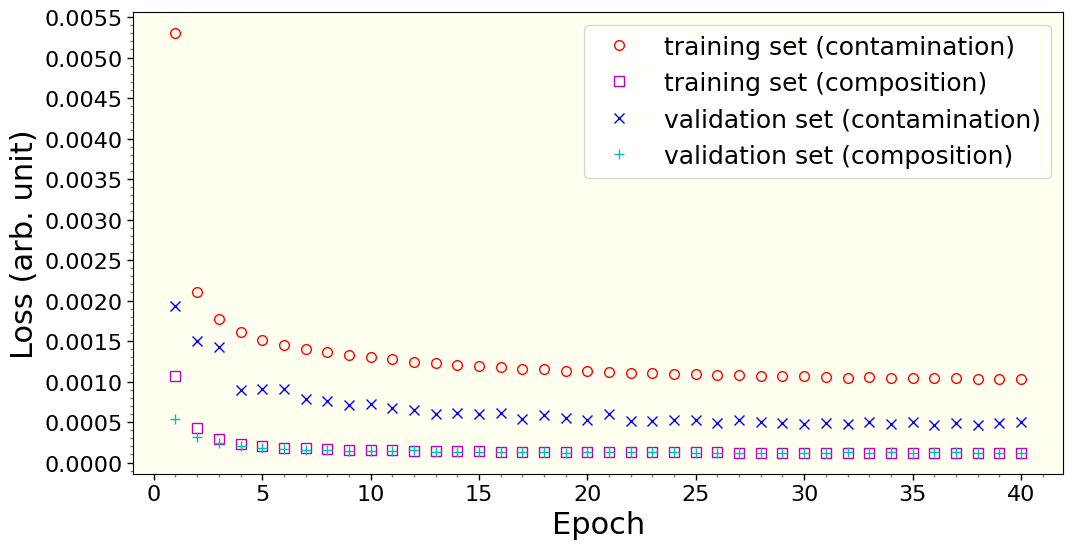

In [9]:
if True:
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
    afile = open("C:/Users/Inho Lee/testAI/trainXPS/model/conv1.txt")
    alist = []
    blist = []
    clist = []
    dlist = []
    elist = []
    for line in afile:
        alist.append(1+int(line.split()[0]))
        blist.append(float(line.split()[1]))
        clist.append(float(line.split()[2]))
        dlist.append(float(line.split()[3]))
        elist.append(float(line.split()[4]))
    afile.close()
    fig, ax = plt.subplots()
    plt.plot(alist, blist, 'ro', markersize=7, markerfacecolor='none', linewidth=3,
         label='training set (contamination)')
    plt.plot(alist, clist, 'ms', markersize=7, markerfacecolor='none', linewidth=3,
         label='training set (composition)')
    plt.plot(alist, dlist, 'bx', markersize=7, markerfacecolor='none', linewidth=3,
         label='validation set (contamination)')
    plt.plot(alist, elist, 'c+', markersize=7, markerfacecolor='none', linewidth=3,
         label='validation set (composition)')
    plt.xlabel('Epoch', fontsize=22)
    plt.ylabel('Loss (arb. unit)', fontsize=22)
    plt.legend(prop={'size': 18})
    ax.set_facecolor('ivory')
    ax.yaxis.set_major_locator(MultipleLocator(0.0005))
    ax.xaxis.set_major_locator(mticker.MultipleLocator(5))
#   ax.yaxis.set_major_formatter('{x:.000f}')
#   For the minor ticks, use no labels; default NullFormatter.
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', width=1)
    ax.tick_params(which='major', length=4)
    ax.tick_params(which='minor', length=2, color='gray')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig("C:/Users/Inho Lee/testAI/trainXPS/model/conv1.eps")
    plt.show()

prediction mode

please place a single file (XPS intensity file) to the fold new/


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
if os.path.exists("C:/Users/Inho Lee/testAI/trainXPS/model/XPS_model1.h5"):
    model = keras.models.load_model(
        "C:/Users/Inho Lee/testAI/trainXPS/model/XPS_model1.h5", compile=False)
    if lhighpass:
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=[losses.Huber(delta=0.08), HighPassLoss])
    else:
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=[losses.MeanSquaredLogarithmicError(), losses.MeanSquaredLogarithmicError()])
    model.summary()

Model: "XPS_CSIAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 1)      11          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 2048, 1)      21          ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 2048, 1)      41          ['input_1[0][0]']                
                                                                                          

In [11]:
def getxps0(directory):
    files = os.listdir(directory)
    formula = ""
    ydum = 0.
    nfiles = 0
    for file in files:
        if file[0] == '.':
            continue
        nfiles = nfiles+1
    x0 = np.zeros(Info.INPUT_SZ)
    X = np.zeros((nfiles, Info.INPUT_SZ), dtype=float)
    y = np.zeros((nfiles, len(Info.SPECIES)+1), dtype=float)
    kase = 0
    for file in files:
        if file[0] == '.':
            continue
        fname = directory + '/' + file
        afile = open(fname, 'r')
        jline = 0
        for line in afile:
            if line.startswith('#'):
                input0 = line
                line0 = line.replace('#', " ")
                line1 = line0.replace('/', " ")
                line2 = line1.replace('[', " ")
                line3 = line2.replace(']', " ")
                ndum = len(line3.split())
                formula = ""
                for i in range(ndum-1):
                    formula = formula+line3.split()[i]
                y[kase, -1] = (float(line3.split()[-1]))/40.
                alist = []
                blist = []
                str2 = get_composition(formula)
                for i in range(len(str2)):
                    a0, a1 = str2[i]
                    blist.append(float(a1))
                tmp = sum(blist)
                blist = [blist[i]/tmp for i in range(len(blist))]
                for i in range(len(str2)):
                    a0, a1 = str2[i]
                    alist.append(blist[i]*Info.T[Info.SPECIES.index(a0)])
                tmq = sum(alist)
                alist = [alist[i]/tmq for i in range(len(alist))]
                for i in range(len(str2)):
                    a0, a1 = str2[i]
                    y[kase, Info.SPECIES.index(a0)] = y[kase,
                                                   Info.SPECIES.index(a0)]+alist[i]
                if False:
                    print(label0(input0))
                    print(y[kase, 0:Info.NSPECIES])
                continue
            X[kase, jline] = float(line.split()[1])
            x0[jline]=float(line.split()[0])
            jline = jline+1
        afile.close()
        kase = kase+1
    return x0, X

00007   001025  002059      000991

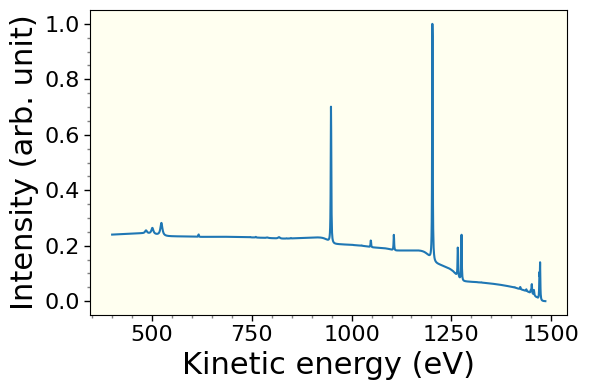

CPU times: total: 156 ms
Wall time: 131 ms


In [58]:
%%time
x0, X = getxps0("C:/Users/Inho Lee/testAI/trainXPS/new")
y0 = np.zeros(Info.INPUT_SZ)
y0[:]=X[0,:]
plt.rcParams['figure.figsize'] = [6, 4]
fig, ax = plt.subplots()
plt.plot(x0,y0)
#plt.title('YS_PARK XPS input data', fontsize=20)
plt.xlabel('Kinetic energy (eV)', fontsize=22)
plt.ylabel('Intensity (arb. unit)', fontsize=22)
ax.set_facecolor('ivory')
# ax.yaxis.set_major_formatter('{x:.000f}')
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_major_locator(MultipleLocator(250))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=1)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2, color='gray')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
if True:
    plt.savefig("C:/Users/Inho Lee/testAI/trainXPS/model/new_in.eps")
plt.show()    

[[0.96775]]
[[0.         0.         0.         0.         0.         0.
  0.         0.32301751 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.02592369 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.01030408
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.0101729  0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.63058183 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]]
0.9571040615439415 0.01552417159033934
[9.26393608e-04 2.84422422e-04 6.77290009e-05 1.11561995e-02
 1.67192004e-04 9.14252712e-04 1.91201743e-05 2.52953291e-01
 4.91191680e-

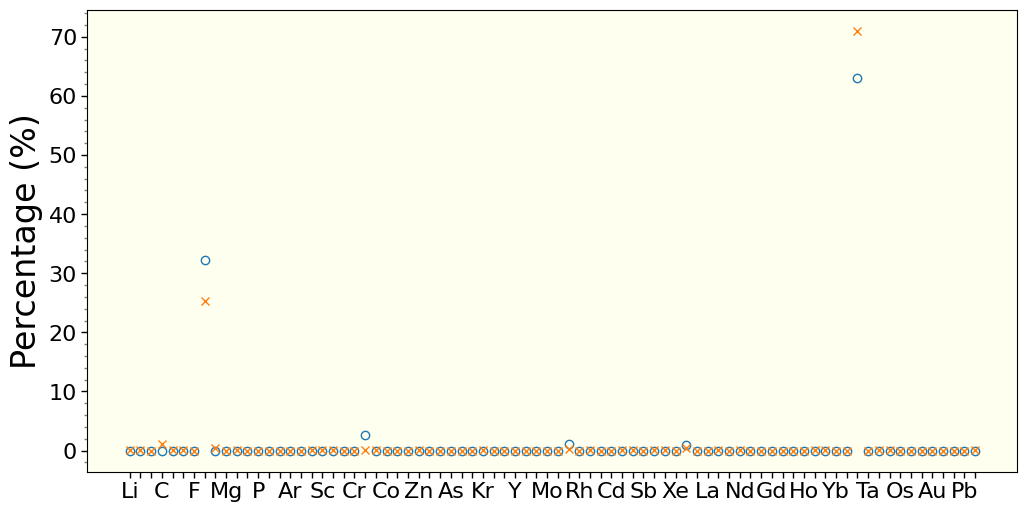

CPU times: total: 8.08 s
Wall time: 6.89 s


In [59]:
%%time
X, y = getxps("C:/Users/Inho Lee/testAI/trainXPS/new")
nsamples = y.shape[0]
lab2 = np.zeros((nsamples, 1), dtype=float)
lab1 = np.zeros((nsamples, Info.NSPECIES), dtype=float)
lab2[:, 0] = y[:, -1]
lab1[:, 0:Info.NSPECIES] = y[:, 0:Info.NSPECIES]
print(lab2)
print(lab1)
ntry = 200
aa = np.zeros((ntry), dtype=float)
bb = np.zeros((ntry, Info.NSPECIES), dtype=float)
for itry in range(ntry):
    pred, pred1 = model.predict(X, verbose=0)
    aa[itry] = aa[itry]+pred[0]
    bb[itry, 0:Info.NSPECIES] = pred1[0:Info.NSPECIES]
print(aa.mean(),aa.std())    
print(pred1.mean(axis=0))
predvec=pred1.mean(axis=0)
truevec=np.zeros(Info.NSPECIES)
truevec[0:Info.NSPECIES]=lab1[0,0:Info.NSPECIES]
for i in range(Info.NSPECIES):
    truevec[i]=truevec[i]*100.
    predvec[i]=predvec[i]*100.
plt.rcParams['figure.figsize'] = [12, 6]    
ind = np.arange(Info.NSPECIES)
zlist=[]
for i in range(len(Info.SPECIES)):
    if np.mod(i,3) == 0 :
        zlist.append(Info.SPECIES[i])
    else:
        zlist.append(" ")
fig, ax = plt.subplots()
plt.xlabel('', fontsize=1)
plt.ylabel('Percentage (%)', fontsize=24)
plt.plot(ind,truevec[0:Info.NSPECIES], marker='o', linestyle='none', markerfacecolor='none')
plt.plot(ind,predvec[0:Info.NSPECIES], marker='x', linestyle='none', markerfacecolor='none')
#plt.xticks(ind, Info.SPECIES, fontsize=7)
plt.xticks(ind, zlist, fontsize=18)
ax.set_facecolor('ivory')
ax.yaxis.set_major_locator(MultipleLocator(10.))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=1)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2, color='gray')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


1.0000000029546987
0.9571040615439415 0.01552417159033934
[1.52824485e-03 1.68373282e-04 3.43937583e-04 2.61519785e-02
 1.41165975e-04 4.82932451e-03 1.72859510e-03 2.54573236e-01
 3.61787371e-03 1.79548351e-04 3.54854564e-04 1.05075651e-03
 1.27736931e-04 1.38894551e-04 5.76968160e-04 2.34539422e-04
 8.48256959e-05 1.33831450e-03 3.16698624e-04 3.17103756e-03
 1.98151351e-04 4.32653382e-04 1.27130085e-03 4.02302814e-04
 3.72449250e-04 1.32070805e-04 1.86452879e-03 8.21005765e-04
 2.39856836e-04 1.98334039e-05 1.33507741e-04 5.36208503e-05
 1.48003862e-05 8.96038357e-04 6.13839373e-06 1.49960342e-04
 1.21910068e-03 3.85239790e-06 2.74127551e-05 1.51885162e-07
 9.25576473e-05 2.60009903e-04 8.87689545e-05 2.12009574e-03
 1.76390491e-04 4.49157048e-05 2.08404973e-03 1.70442454e-04
 1.50381552e-04 3.58089946e-04 9.98437795e-04 3.52821052e-05
 2.93388908e-03 1.59942076e-05 2.18760629e-05 1.67610730e-03
 4.17801412e-05 7.48806208e-04 6.01942306e-04 3.30879497e-04
 9.88457318e-05 9.39871978e

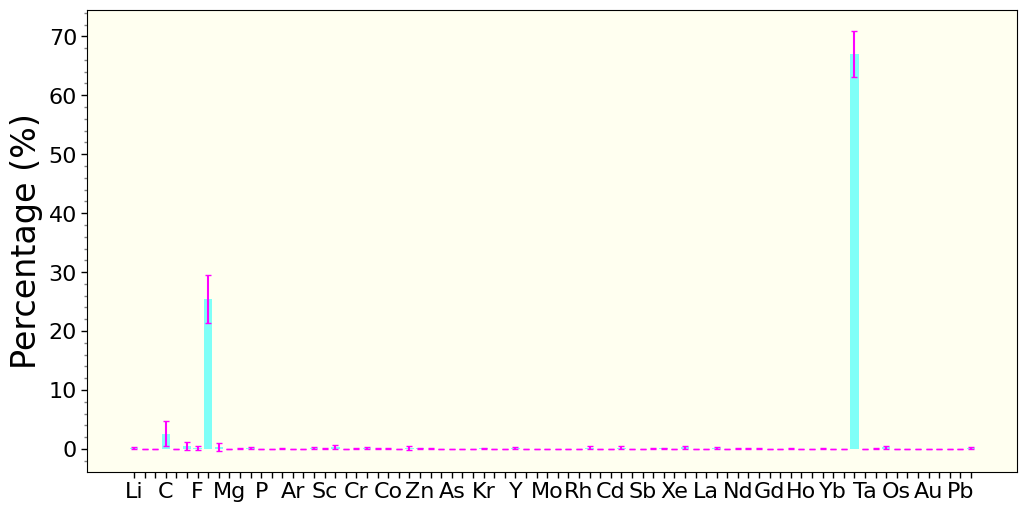

CPU times: total: 484 ms
Wall time: 481 ms


In [60]:
%%time
plt.rcParams['figure.figsize'] = [12, 6]
#plt.rcParams.update({'errorbar.capsize': 2})
ecolors = ['magenta' for _ in range(Info.NSPECIES)]
t1sum = sum(bb.mean(axis=0))
print(t1sum)
print(aa.mean(), aa.std())
print(bb.mean(axis=0))
print(bb.std(axis=0))
ind = np.arange(Info.NSPECIES)
zlist=[]
for i in range(len(Info.SPECIES)):
    if np.mod(i,3) == 0 :
        zlist.append(Info.SPECIES[i])
    else:
        zlist.append(" ")
        
predvec=np.zeros(Info.NSPECIES)
prederr=np.zeros(Info.NSPECIES)
predvec[0:Info.NSPECIES] = bb.mean(axis=0)[0:Info.NSPECIES]
prederr[0:Info.NSPECIES] = bb.std(axis=0)[0:Info.NSPECIES]
for i in range(Info.NSPECIES):
    predvec[i]=predvec[i]*100.
    prederr[i]=prederr[i]*100.  #*1.96
fig, ax = plt.subplots()
plt.bar(ind, predvec, yerr=prederr,
        color='cyan', alpha=0.5, ecolor='magenta', capsize=2)

#plt.title('YS_PARK XPS output data', fontsize=20)
plt.xlabel('', fontsize=1)
plt.ylabel('Percentage (%)', fontsize=24)
#plt.xticks(ind, Info.SPECIES, fontsize=7)
plt.xticks(ind, zlist, fontsize=18)
ax.set_facecolor('ivory')
ax.yaxis.set_major_locator(MultipleLocator(10.))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=1)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2, color='gray')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
if True:
    plt.savefig("C:/Users/Inho Lee/testAI/trainXPS/model/new_out.eps")
plt.show()    

In [15]:
import numpy.linalg as LA

In [16]:
X, y = getxps("C:/Users/Inho Lee/testAI/trainXPS/test/dir_1")
nsamples = y.shape[0]
lab2 = np.zeros((nsamples, 1), dtype=float)
lab1 = np.zeros((nsamples, Info.NSPECIES), dtype=float)
lab2[:, 0] = y[:, -1]
lab1[:, 0:Info.NSPECIES] = y[:, 0:Info.NSPECIES]

asum1 = np.zeros((nsamples), dtype=float)
bsum1 = np.zeros((nsamples), dtype=float)
asum2 = np.zeros((nsamples), dtype=float)
bsum2 = np.zeros((nsamples), dtype=float)
for i in range(nsamples):
    if False:
        print(lab2[i, 0])
        print(lab1[i, :])
    if True:
        ntry = 200
        aa = np.zeros((ntry), dtype=float)
        bb = np.zeros((ntry, Info.NSPECIES), dtype=float)
        for itry in range(ntry):
            pred, pred1 = model.predict(X[i:i+1,:], verbose=0)
            aa[itry] = aa[itry]+pred[0]
            bb[itry, 0:Info.NSPECIES] = pred1[0:Info.NSPECIES]
           # print(aa.mean(), aa.std())
           # print(pred1.mean(axis=0))
            asum1[i]=np.abs(lab2[i,0]-aa.mean())
            bsum1[i]=np.max(np.abs(lab1[i,:]-pred1.mean(axis=0)))
print( np.sqrt(asum1.mean()) )
print( bsum1.mean())      

0.14253551101925302
0.06326549615198955


In [17]:
X, y = getxps("C:/Users/Inho Lee/testAI/trainXPS/test/dir_2")
nsamples = y.shape[0]
lab2 = np.zeros((nsamples, 1), dtype=float)
lab1 = np.zeros((nsamples, Info.NSPECIES), dtype=float)
lab2[:, 0] = y[:, -1]
lab1[:, 0:Info.NSPECIES] = y[:, 0:Info.NSPECIES]

asum1 = np.zeros((nsamples), dtype=float)
bsum1 = np.zeros((nsamples), dtype=float)
asum2 = np.zeros((nsamples), dtype=float)
bsum2 = np.zeros((nsamples), dtype=float)
for i in range(nsamples):
    if False:
        print(lab2[i, 0])
        print(lab1[i, :])
    if True:
        ntry = 200
        aa = np.zeros((ntry), dtype=float)
        bb = np.zeros((ntry, Info.NSPECIES), dtype=float)
        for itry in range(ntry):
            pred, pred1 = model.predict(X[i:i+1,:], verbose=0)
            aa[itry] = aa[itry]+pred[0]
            bb[itry, 0:Info.NSPECIES] = pred1[0:Info.NSPECIES]
           # print(aa.mean(), aa.std())
           # print(pred1.mean(axis=0))
            asum1[i]=np.abs(lab2[i,0]-aa.mean())
            bsum1[i]=np.max(np.abs(lab1[i,:]-pred1.mean(axis=0)))
print( np.sqrt(asum1.mean()) )
print( bsum1.mean())      

0.1293301853403615
0.05839419706811843


In [18]:
X, y = getxps("C:/Users/Inho Lee/testAI/trainXPS/test/dir_3")
nsamples = y.shape[0]
lab2 = np.zeros((nsamples, 1), dtype=float)
lab1 = np.zeros((nsamples, Info.NSPECIES), dtype=float)
lab2[:, 0] = y[:, -1]
lab1[:, 0:Info.NSPECIES] = y[:, 0:Info.NSPECIES]

asum1 = np.zeros((nsamples), dtype=float)
bsum1 = np.zeros((nsamples), dtype=float)
asum2 = np.zeros((nsamples), dtype=float)
bsum2 = np.zeros((nsamples), dtype=float)
for i in range(nsamples):
    if False:
        print(lab2[i, 0])
        print(lab1[i, :])
    if True:
        ntry = 200
        aa = np.zeros((ntry), dtype=float)
        bb = np.zeros((ntry, Info.NSPECIES), dtype=float)
        for itry in range(ntry):
            pred, pred1 = model.predict(X[i:i+1,:], verbose=0)
            aa[itry] = aa[itry]+pred[0]
            bb[itry, 0:Info.NSPECIES] = pred1[0:Info.NSPECIES]
           # print(aa.mean(), aa.std())
           # print(pred1.mean(axis=0))
            asum1[i]=np.abs(lab2[i,0]-aa.mean())
            bsum1[i]=np.max(np.abs(lab1[i,:]-pred1.mean(axis=0)))
print( np.sqrt(asum1.mean()) )
print( bsum1.mean())      

0.13025273121612
0.05768134966674564


https://www.kaggle.com/code/latong/multihead-attention

In [ ]:
!pip install keras-multi-head

In [ ]:
https://stackoverflow.com/questions/76290333/error-calculation-of-a-5-dimensional-vector

In [ ]:
import numpy as np

# Create a 5d array
array = np.random.rand(2, 4, 8, 6, 2)

# Flatten the array into a 1d array
flt_arr = array.ravel()

# Calculate the mean and standard deviation 
mean = np.mean(flt_arr)
std = np.std(flt_arr)

# Choose a confidence level and find the corresponding z value
#where z is the critical value for the desired confidence level, and standard_error is the standard deviation divided by the square root of sample size.
confidence_level = 0.95 
z = 1.96 

# Calculate sample size
sample_size = np.size(flt_arr)

# Calculate standard error
standard_error = std / np.sqrt(sample_size)

# Calculate margin of error
margin_of_error = z * standard_error


print("Mean:", mean)
print("Standard deviation:", std)
print("Standard error:", standard_error)
print("Margin of error:", margin_of_error)